# Ulcerative Colitis: data analysis for XAUT1-Biopsies

Author: Yang-Joon Kim
last updated: 1/25/2023


## Load the datasets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import os
import scvi
import sys
import tqdm

sys.path.append('/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/')
import utils

Global seed set to 0


In [2]:
# make folder for processed adata object and figures
data_directory = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/annotated_data/'

#figure_directory = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/figures/XAUT1-Biopsies/'

sc.settings.figdir = '/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/Manuscript/Figures/XAUT1/'

# if not os.path.exists(data_directory):
#     os.makedirs(data_directory)
# if not os.path.exists(figure_directory):
#     os.makedirs(figure_directory)    

#print package versions
print('package versions:')
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

# # make sure you use these two parameters before saving figures to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=600)

package versions:
numpy 1.21.0
pandas 1.5.2
seaborn 0.11.2
scanpy 1.8.2
scvi 0.16.1
tqdm 4.61.2


In [3]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import ks_2samp
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import tifffile
import fs
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [22]:
# adata_RNA (RNA anndata)
adata_RNA = sc.read_h5ad('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/Cellxgene/MK_version/22_6_13_biopsy_RNA.h5ad')
adata_RNA

AnnData object with n_obs × n_vars = 93900 × 28638
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'nCount_ADT', 'nFeature_ADT', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'CoLabs_sample', 'BIOS_ID', 'patient_short', 'coarse_annotations_MK', 'coarse_annotations_MK a4B7 RNA', 'coarse_annotations_MK a4B7 ADT', 'Endoscopic_Severity_V1', 'fine_annotations_MK_V4'
    var: 'assay'
    uns: 'fine_annotations_MK_V3_colors', 'fine_annotations_MK_V4_colors', 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances'

In [5]:
# adata_ADT (ADT anndata)
adata_ADT = sc.read_h5ad('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/Cellxgene/MK_version/22_6_13_biopsy_ADT.h5ad')
adata_ADT

AnnData object with n_obs × n_vars = 93900 × 177
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'nCount_ADT', 'nFeature_ADT', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'CoLabs_sample', 'BIOS_ID', 'patient_short', 'coarse_annotations_MK', 'coarse_annotations_MK a4B7 RNA', 'coarse_annotations_MK a4B7 ADT', 'Endoscopic_Severity_V1', 'fine_annotations_MK_V4'
    var: 'assay'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances'

## 1. dot plots for RNA

In [11]:
sc.tl.rank_genes_groups(adata_RNA, groupby='coarse_annotations_MK', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:43)


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_coarse_annotations_MK']`


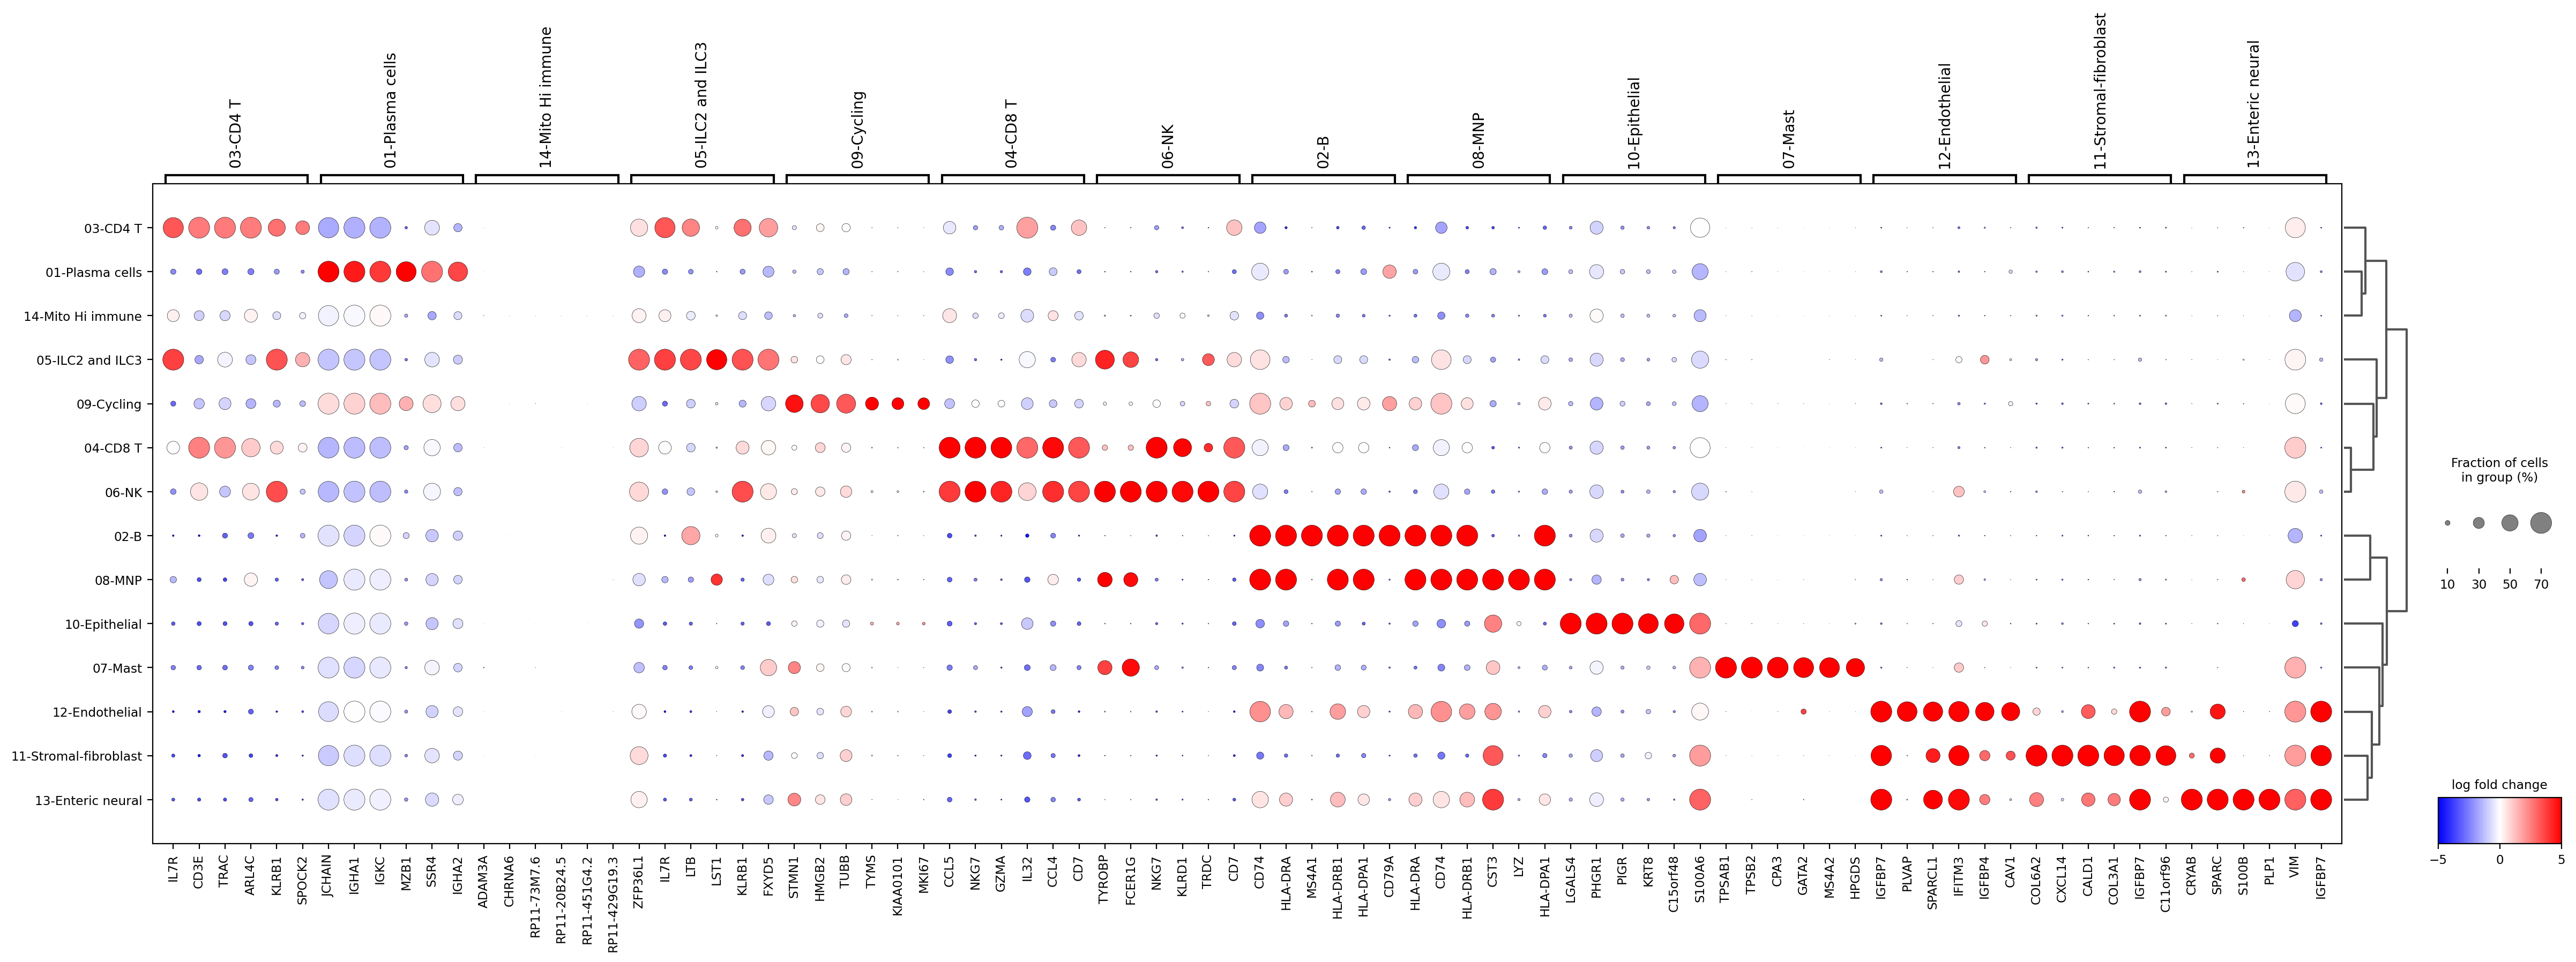

In [12]:
# plot the result of the wilcoxon rank sum test for the adata object
sc.pl.rank_genes_groups_dotplot(adata_RNA, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=2.5,
                                vmax=5, vmin=-5, cmap='bwr', figsize=(29,8), dot_max=0.7, show=True,
                                save="22_6_13_biopsy_all_coarse_dot_sized_lower.pdf")

## subset the anndata with the fine cell type groups

In [13]:
# Subsetting the AnnData with some fine cell-type groups
adata = adata_RNA.copy()
adata_B = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['02A-B naive',"02B-B memory",'02C-B GC and cycling'])]
adata_plasma = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['01A-Plasma cells IgA',
     "01B-Plasma cells IgM",
     '01C-Plasma cells IgG'])]
adata_CD4 = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['03A-CD4 naive',
     '03B-CD4 activated and memory',
     '03C-Treg'])]
adata_CD8 = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['04A-CD8 Tem',
     '04B-CD8 Trm',
     '04C-gd T',
     '05-NK'])]
adata_MNP = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['08A-MNP gut resident macrophage and moDC',
     '08B-MNP inflammatory macrophage',
     '08C-MNP cDC1_cDC2_activated',
     '08D-MNP-pDC'])]
adata_CYCLING = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['09A-Cycling T',
     '09B-Cycling plasmablast',
     '09C-Cycling B',
     '09D-Cycling epithelial'])]
adata_EPITHELIAL = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['10A-Epithelial absorptive colonocyte',
     '10B-Epithelial ISC',
     '10C-Epithelial goblet',
     '10D-Epithelial TA',
     '10E-Epithelial BEST4 OTOP2',
     '10F-Epithelial DCS',
     '10G-Epithelial EEC',
    '10H-Epithelial Tuft'])]
adata_STROMAL = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['11A-Pericyte',
     '11B-Stromal myofibroblasts',
     '11C-Stromal activated fibroblast',
     '11D-Stromal S2',
     '11E-Stromal S1',
     '11F-Stromal-S3',
     '11G-Stromal S4'])]
adata_ENDOTHELIAL = adata[adata.obs["fine_annotations_MK_V3"].isin(
    ['12A-Endothelial lymphatic',
     '12B-Endothelial venous',
     '12C-Endothelial arterial'])]

In [14]:
# perform the Wilcoxon rank sum test for subsetted anndata
sc.tl.rank_genes_groups(adata, groupby='coarse_annotations_MK', method='wilcoxon')
sc.tl.rank_genes_groups(adata_B, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_plasma, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CD4, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CD8, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_MNP, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_CYCLING, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_EPITHELIAL, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_STROMAL, groupby='fine_annotations_MK_V3', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ENDOTHELIAL, groupby='fine_annotations_MK_V3', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:47)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:26)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:50)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)
ranking genes


Trying to set attribute `._uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


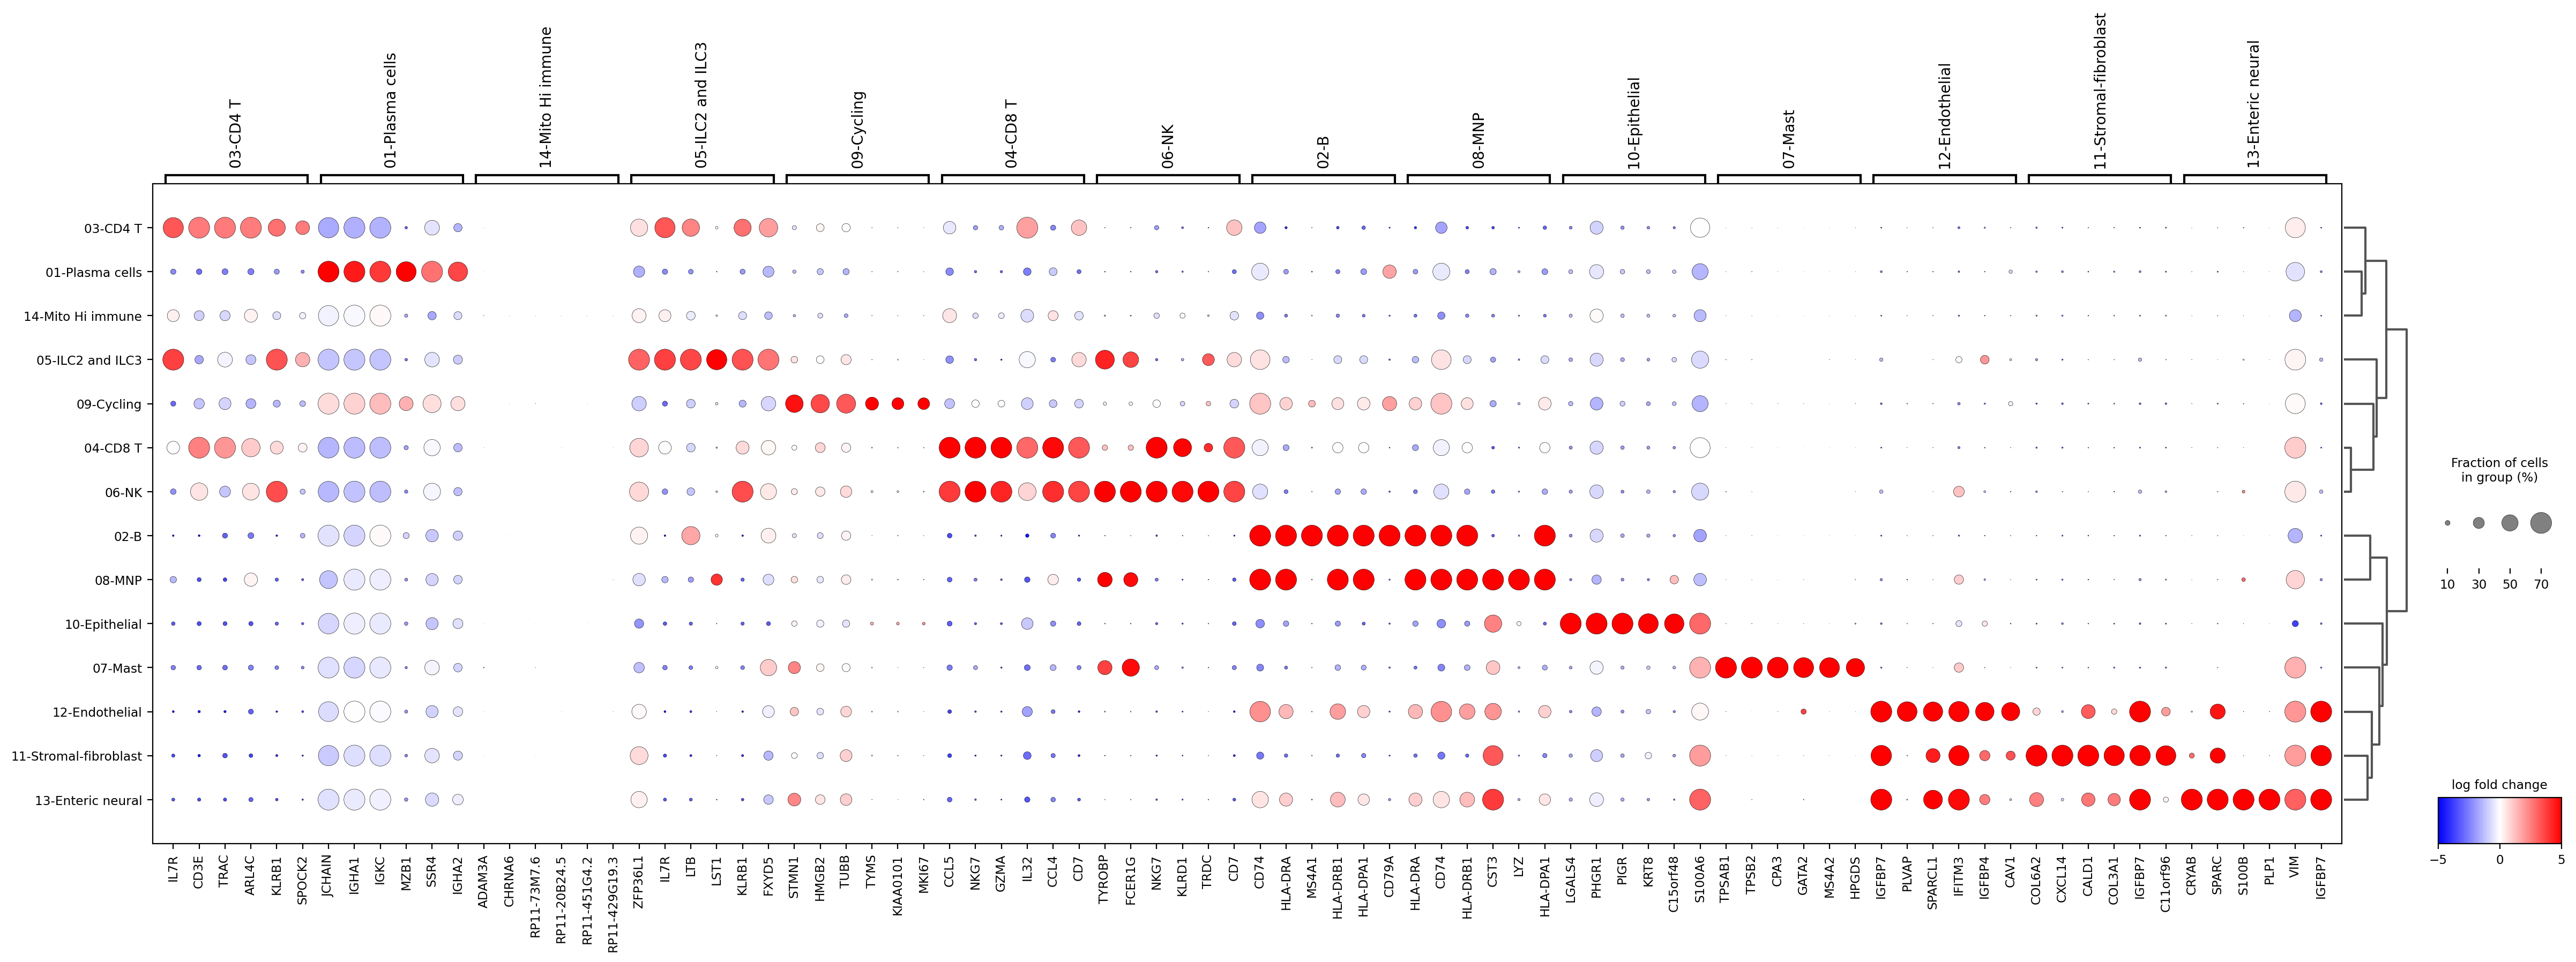

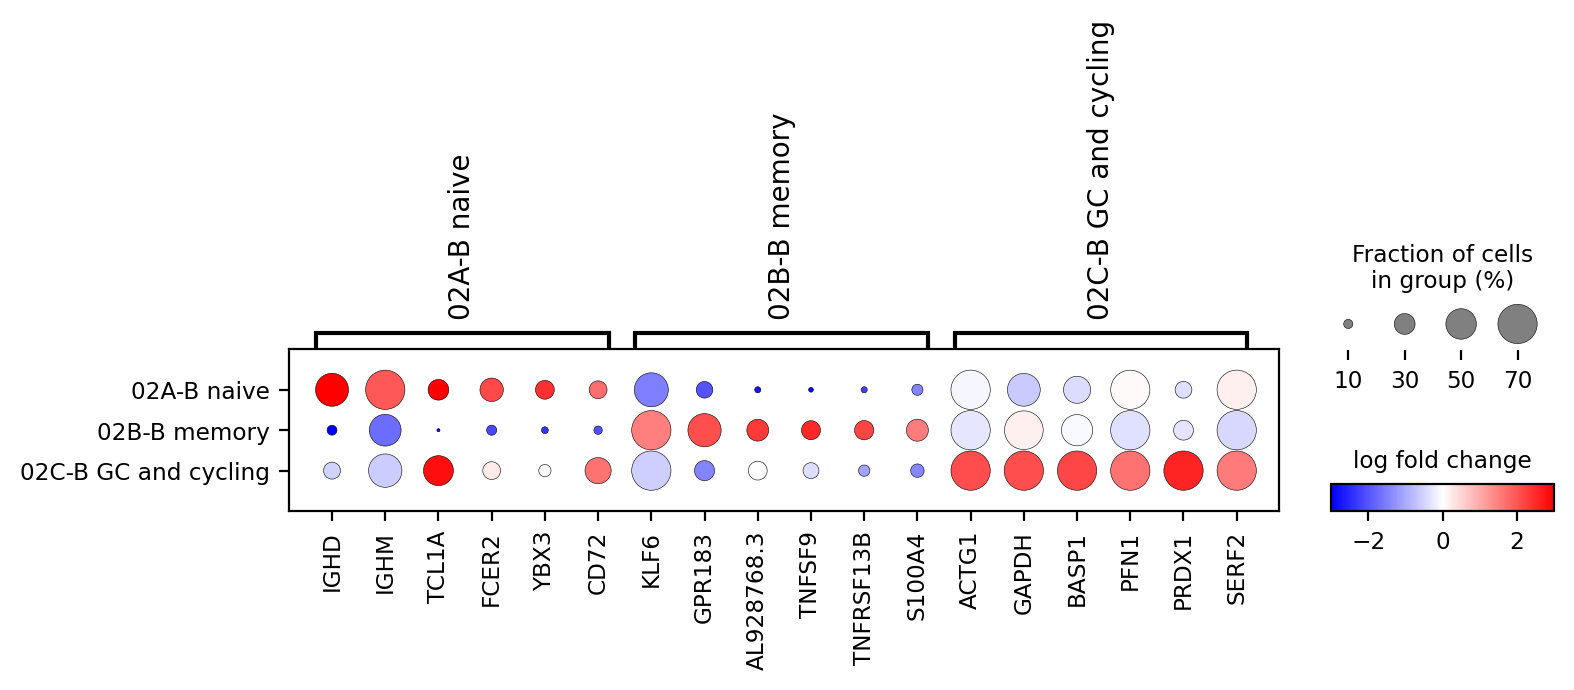

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


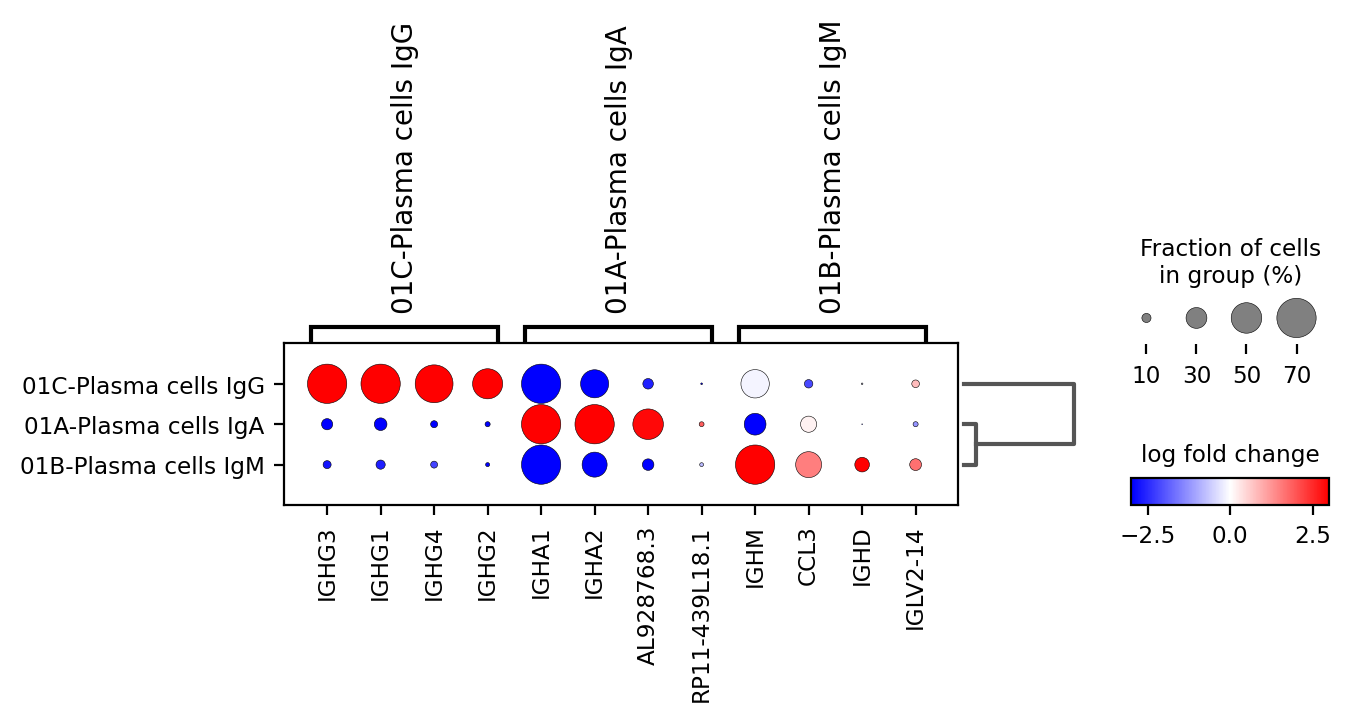

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


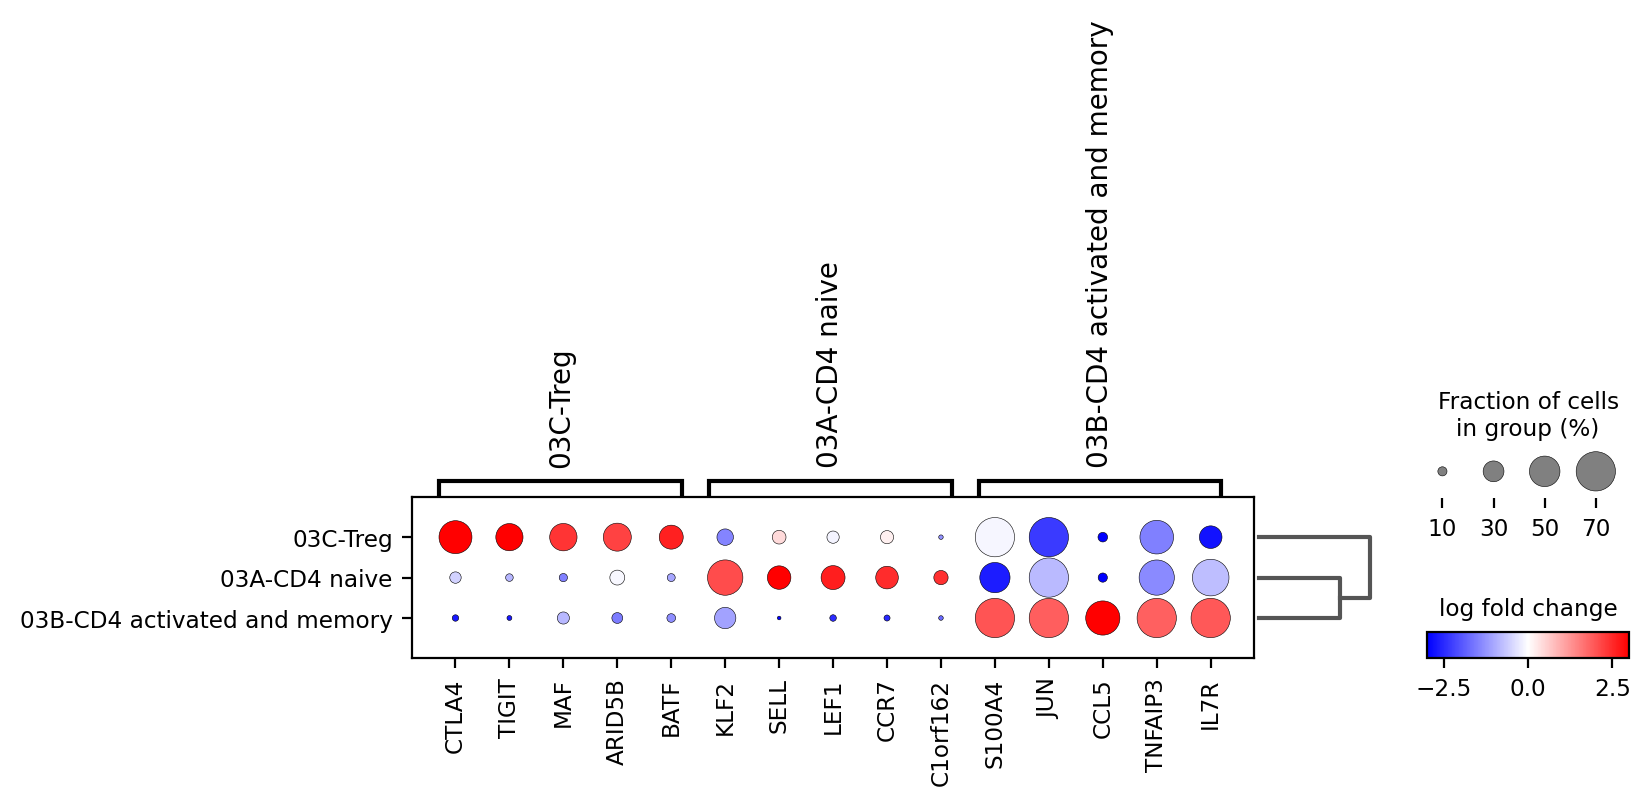

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


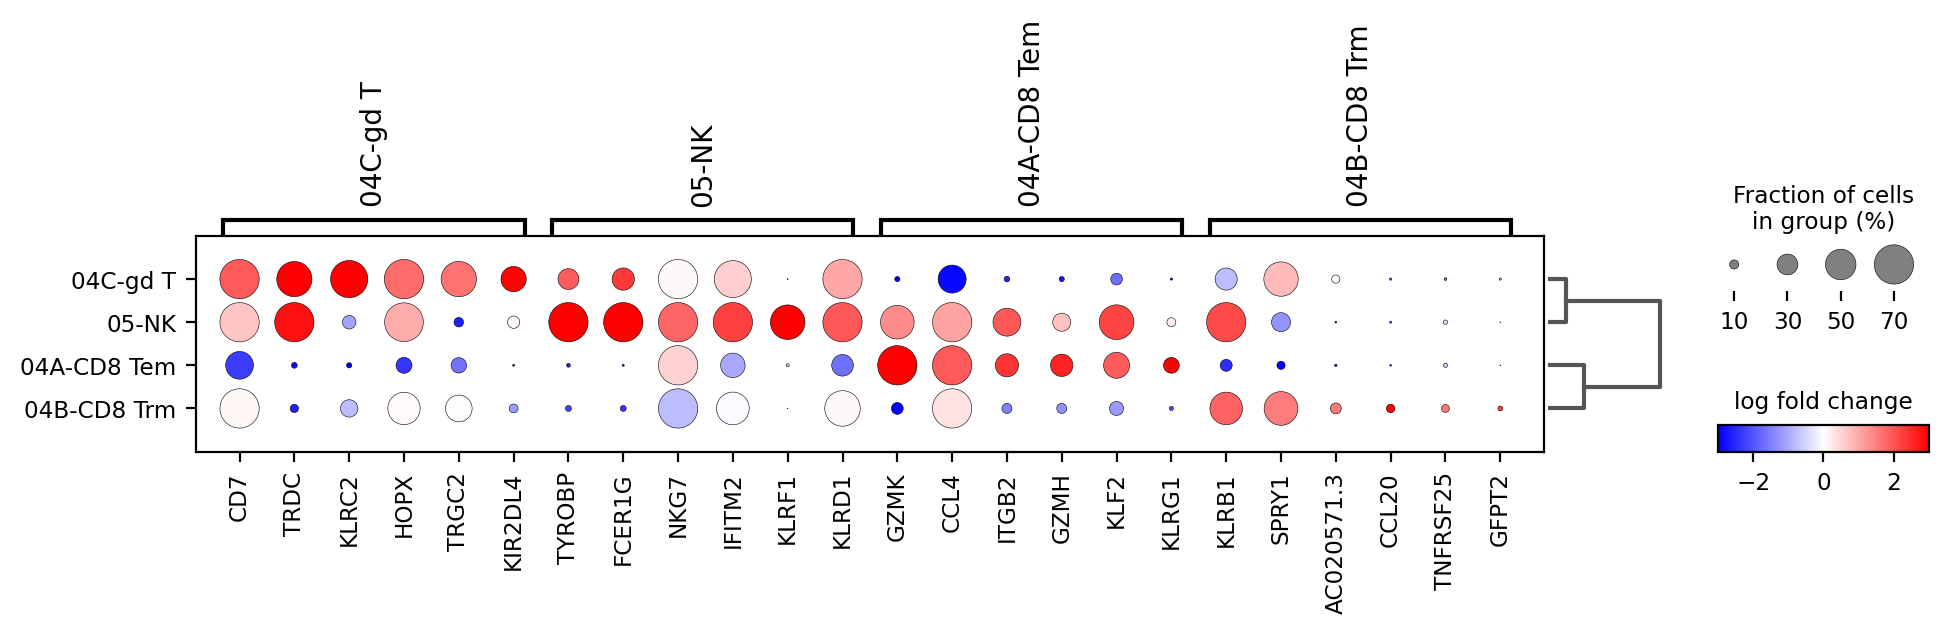

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


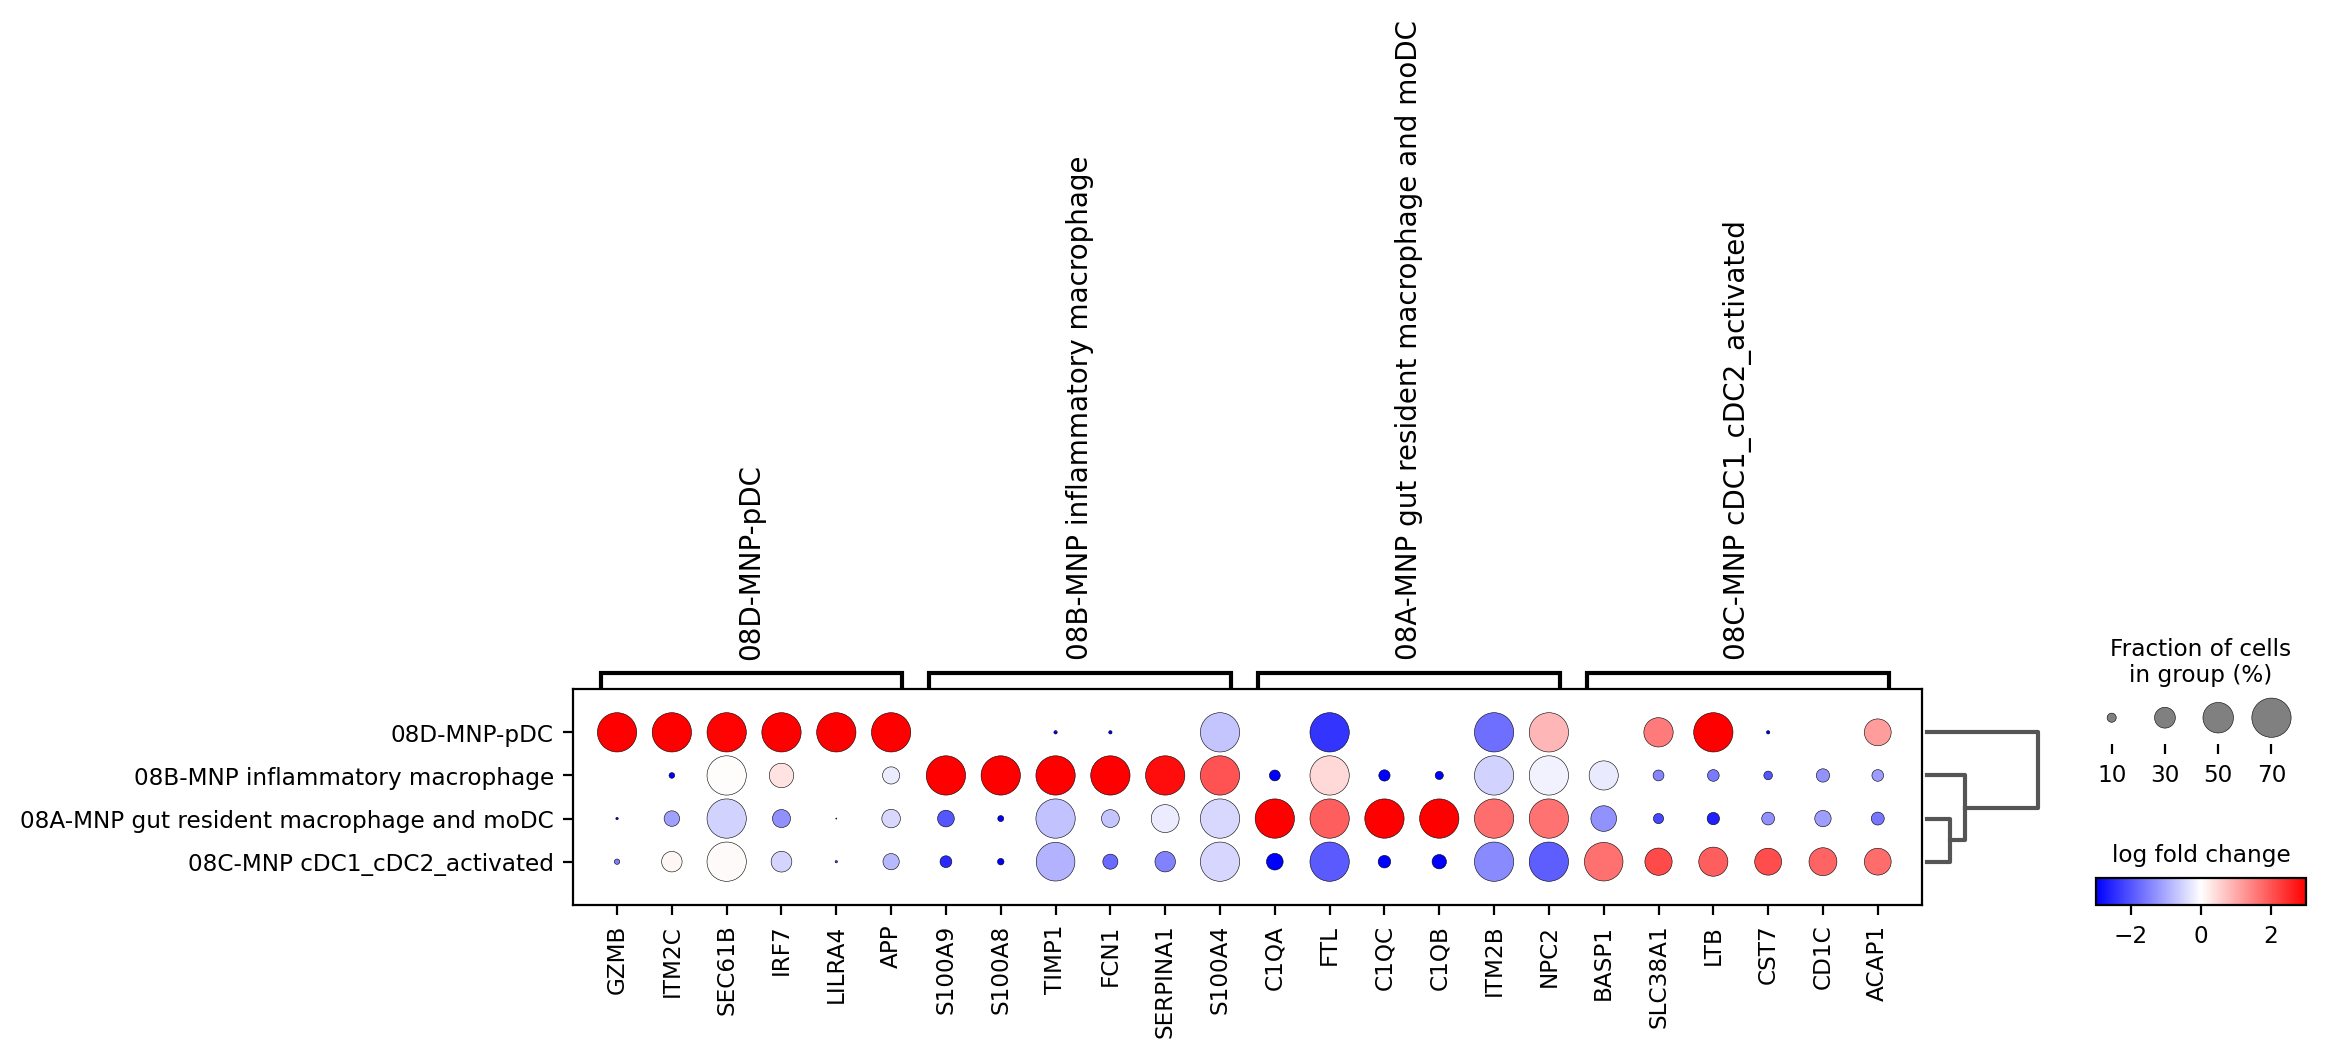

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


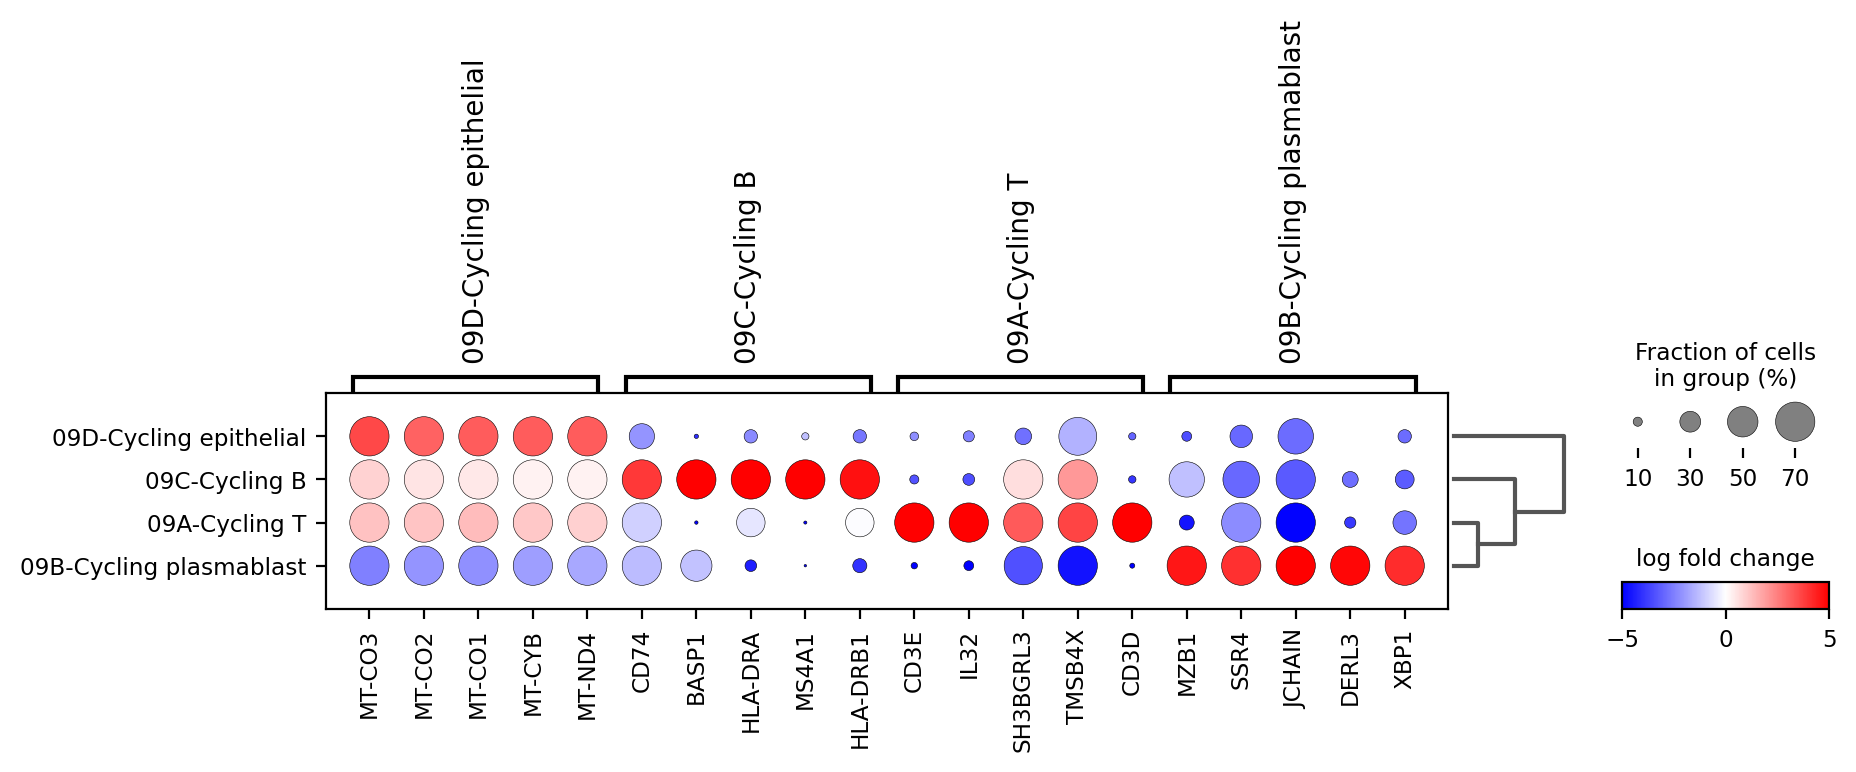

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


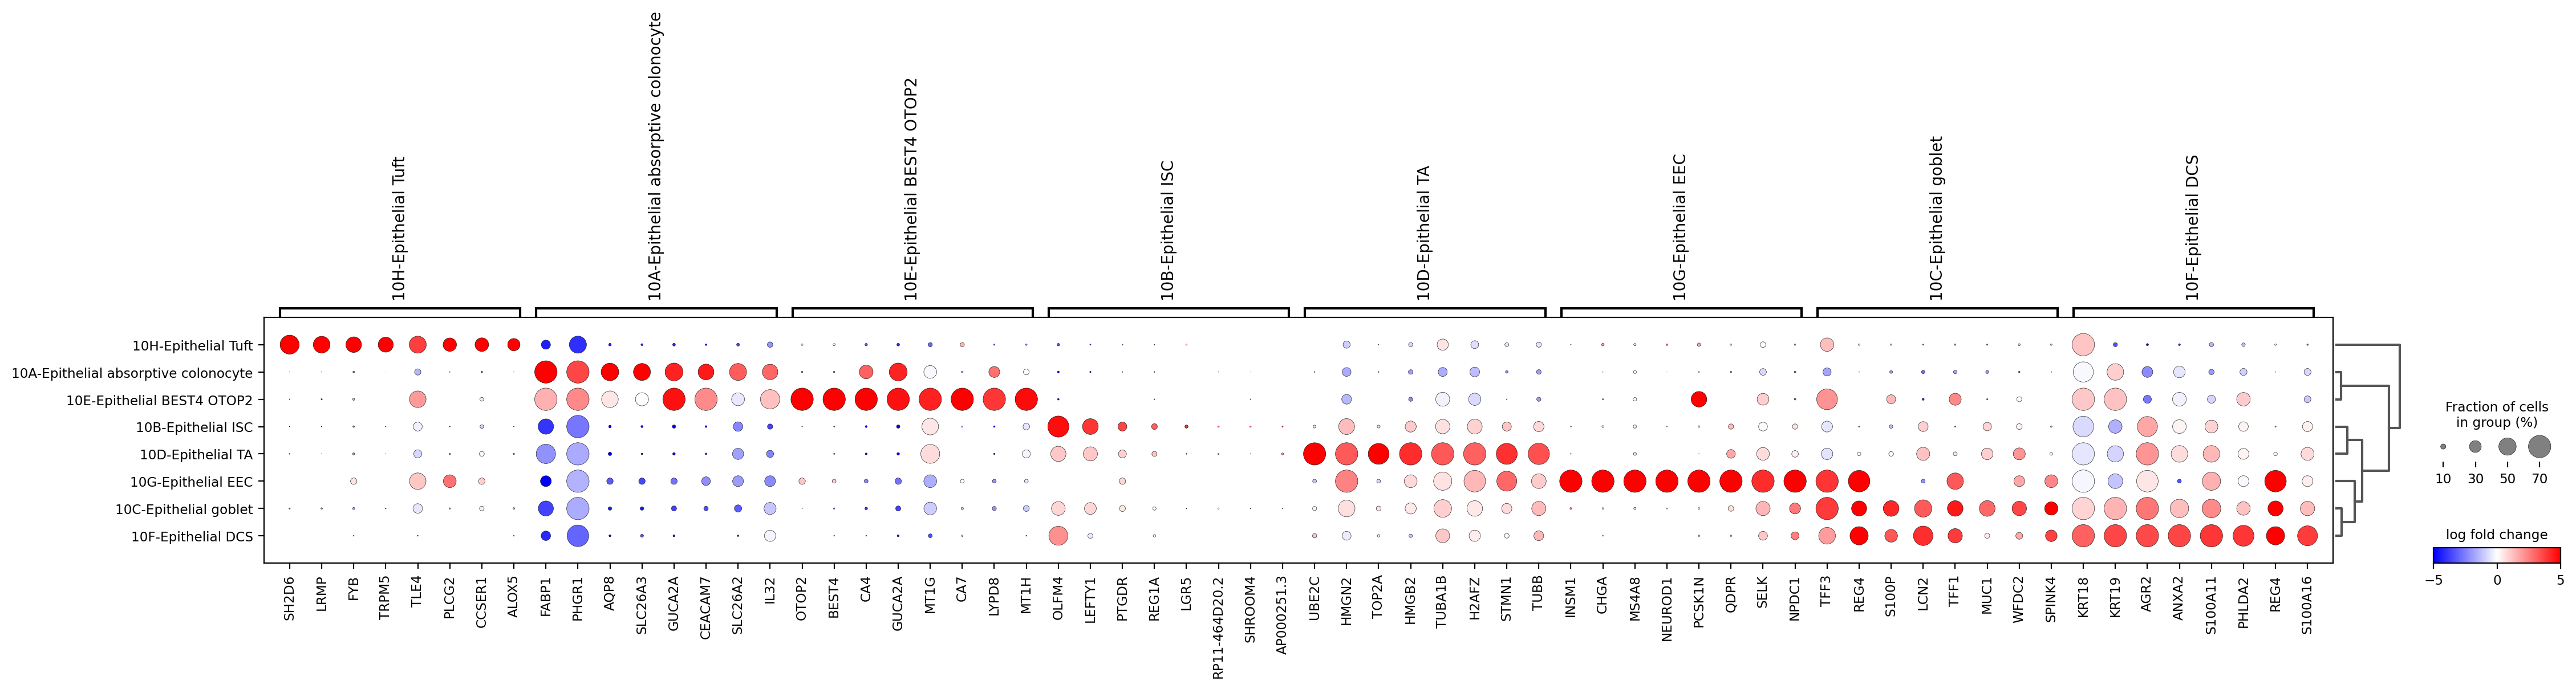

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


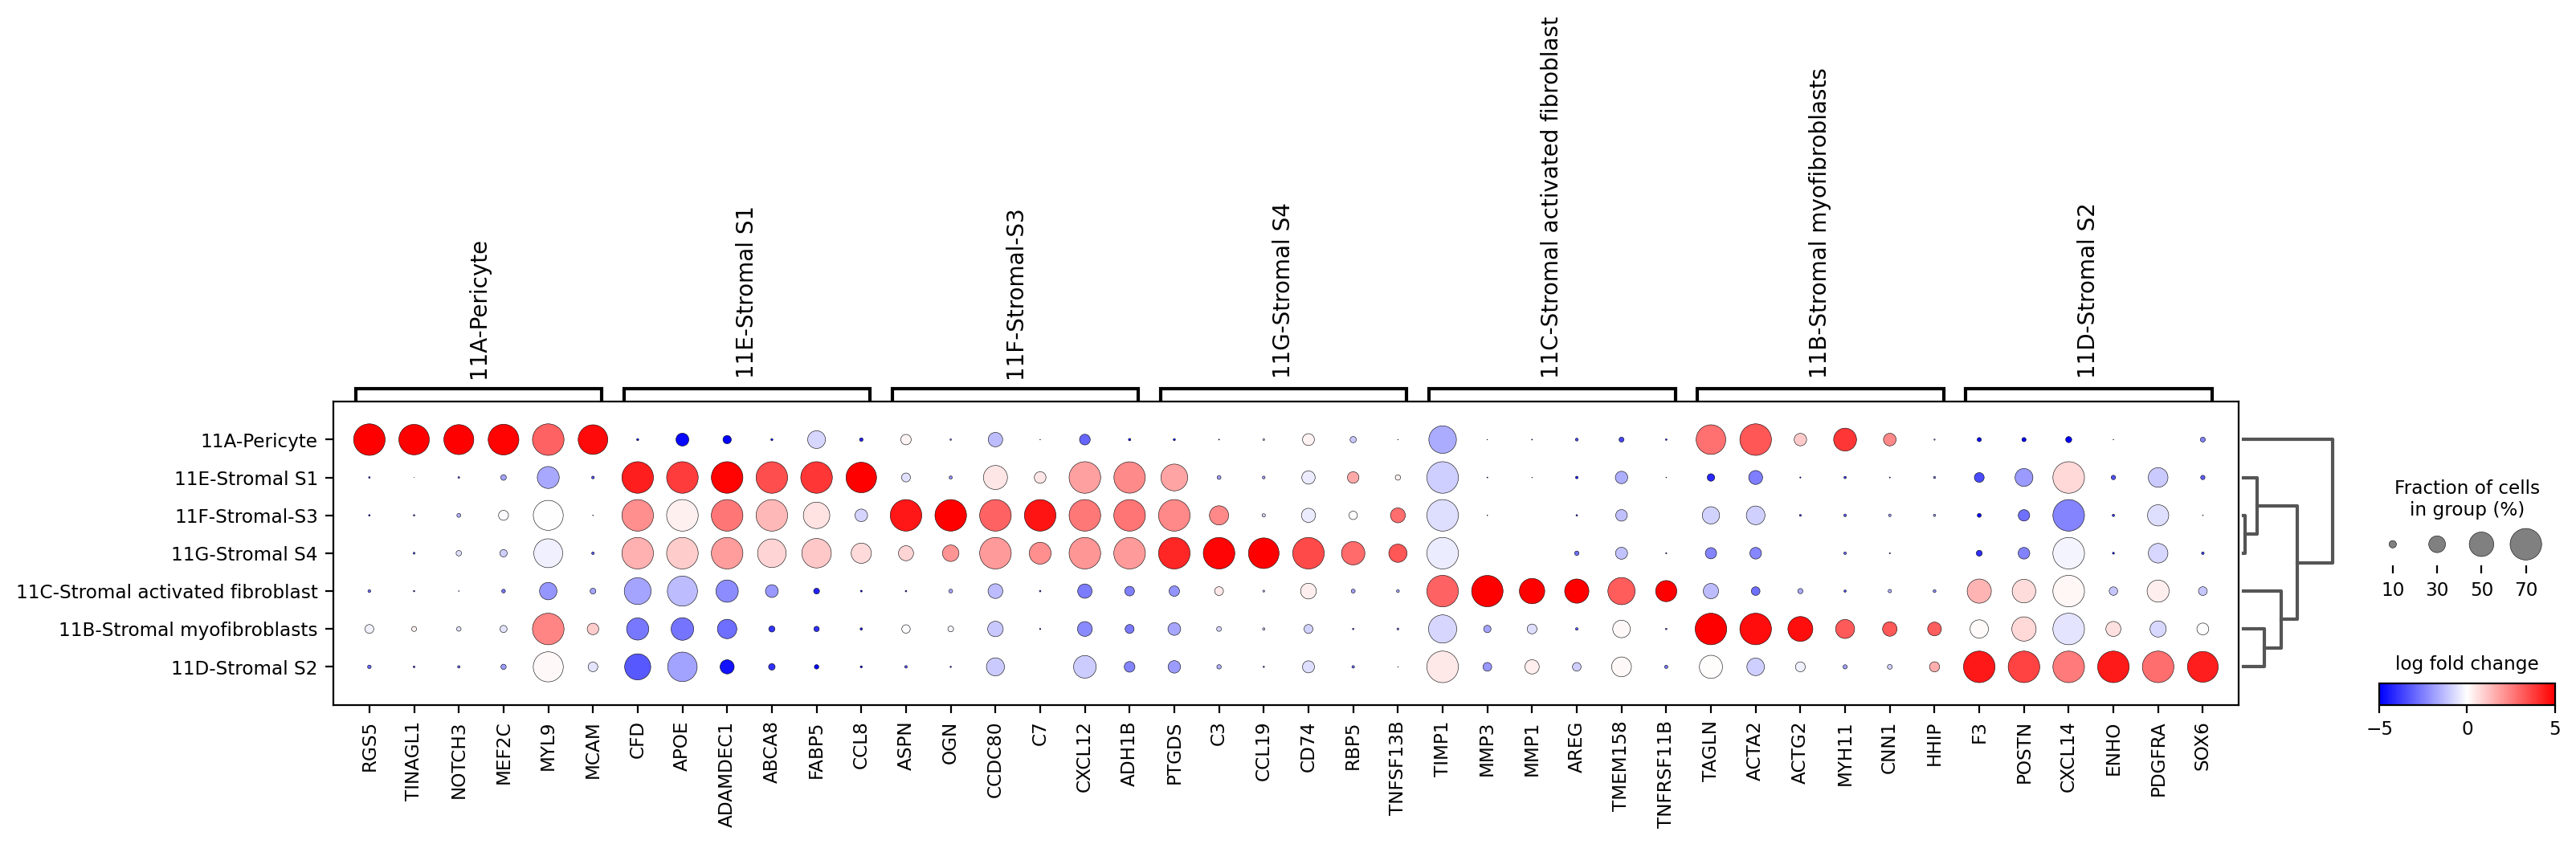

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V3']`


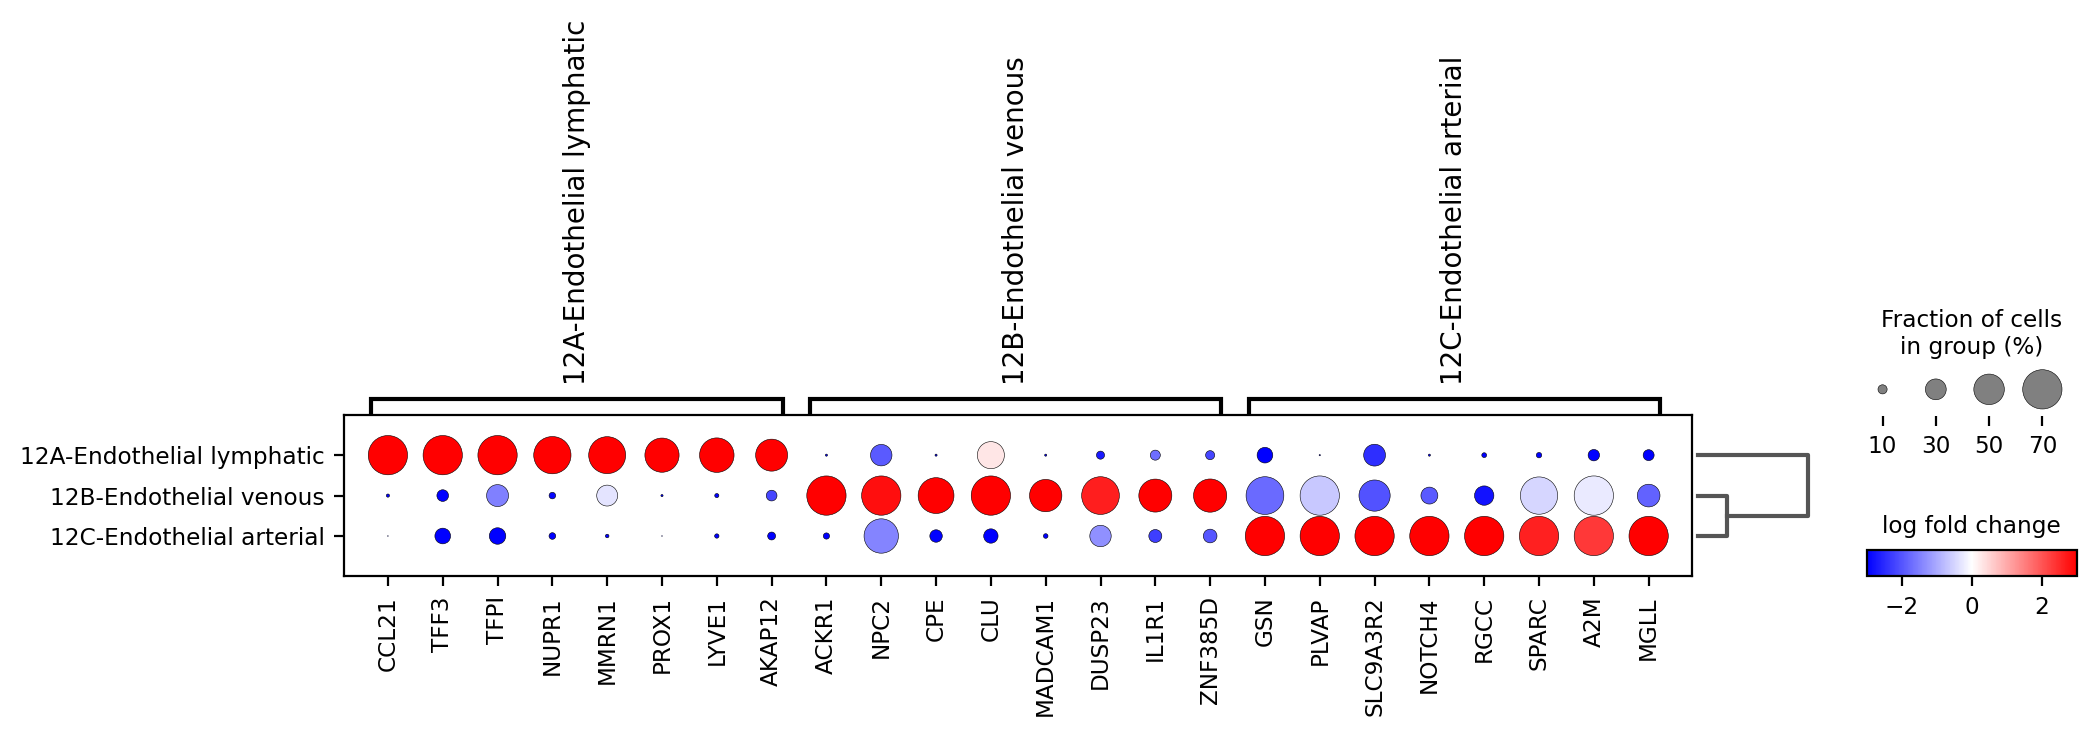

In [15]:
# NOTE: The style has to be modified as we set the threshold for the log-foldchange differently for each plot

sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, values_to_plot='logfoldchanges', 
                                min_logfoldchange=2.5, vmax=5, vmin=-5, cmap='bwr', 
                                figsize=(29,8), dot_max=0.7, 
                                save="22_6_13_biopsy_coarse_dot_plot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_B, n_genes=6, values_to_plot='logfoldchanges', 
                                min_logfoldchange=1.5, vmax=3, vmin=-3, 
                                cmap='bwr', dot_max=0.7, dendrogram=False, 
                                save="22_6_13_biopsy_B_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_plasma, n_genes=4, values_to_plot='logfoldchanges',
                                dot_max=0.7, min_logfoldchange=1.5, vmax=3, vmin=-3, cmap='bwr', 
                                save="22_6_13_biopsy_plasma_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_CD4, n_genes=5, values_to_plot='logfoldchanges',
                                dot_max=0.7, min_logfoldchange=1.75, vmax=3, vmin=-3, cmap='bwr',
                                save="22_6_13_biopsy_CD4_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_CD8, n_genes=6, values_to_plot='logfoldchanges',
                                dot_max=0.7, min_logfoldchange=1.5, vmax=3, vmin=-3, cmap='bwr',
                                save="22_6_13_biopsy_CD8_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_MNP, n_genes=6, values_to_plot='logfoldchanges',
                                dot_max=0.7, min_logfoldchange=1.5, vmax=3, vmin=-3, cmap='bwr',
                                save="22_6_13_biopsy_MNP_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_CYCLING, n_genes=5, values_to_plot='logfoldchanges', 
                                dot_max=0.7, min_logfoldchange=3, vmax=5, vmin=-5, cmap='bwr', 
                                save="22_6_13_biopsy_cycling_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_EPITHELIAL, n_genes=8, values_to_plot='logfoldchanges', 
                                dot_max=0.7, min_logfoldchange=3, vmax=5, vmin=-5, cmap='bwr', 
                                save="22_6_13_biopsy_EPITHELIAL_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_STROMAL, n_genes=6, values_to_plot='logfoldchanges', 
                                dot_max=0.7, min_logfoldchange=2.5, vmax=5, vmin=-5, cmap='bwr', 
                                save="22_6_13_biopsy_STROMAL_fine_dot.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ENDOTHELIAL, n_genes=8, values_to_plot='logfoldchanges', 
                                dot_max=0.7, min_logfoldchange=2, vmax=3, vmin=-3, cmap='bwr', 
                                save="22_6_13_biopsy_ENDOTHELIAL_fine_dot.pdf")

## UMAP visualization

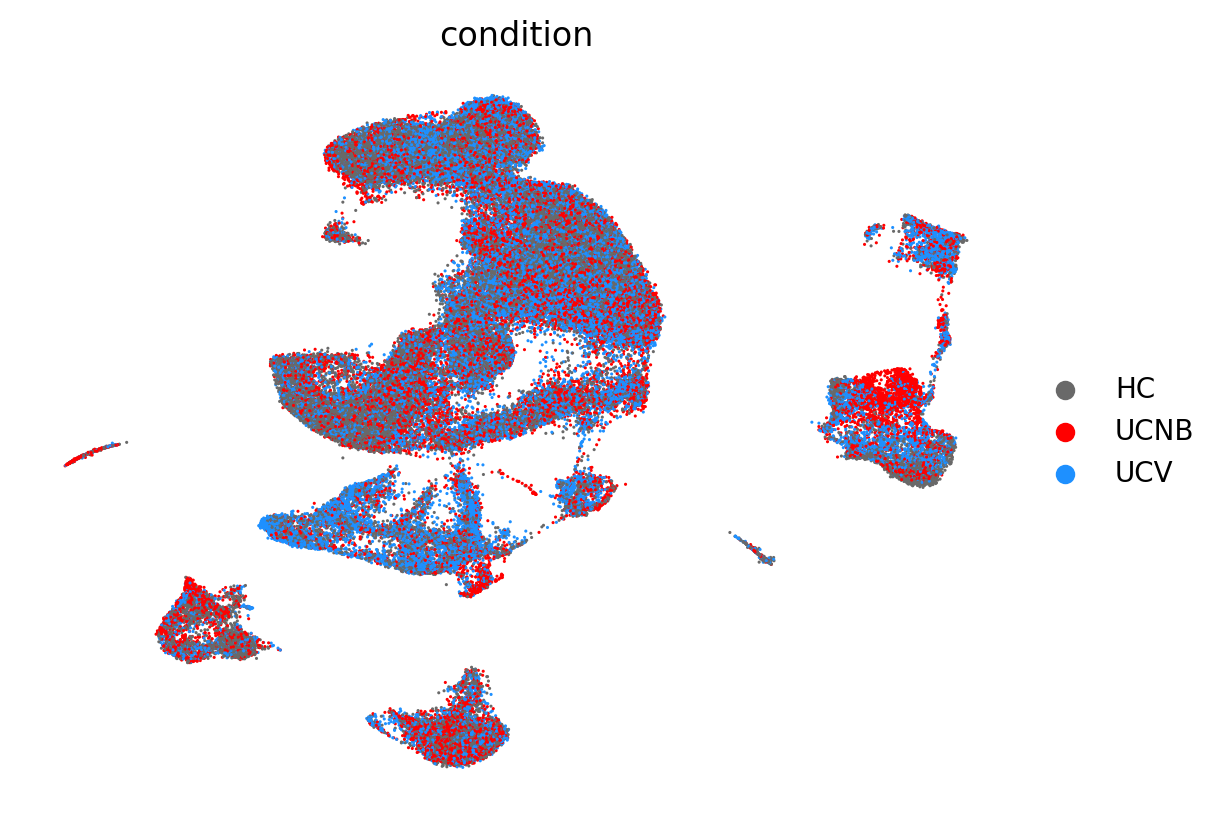

In [16]:
# visualization for different "conditions"
adata = adata[adata.obs["condition"].isin(["HC", "UCNB", "UCV"])].copy()
sc.pl.umap(
    adata,
    color="condition",
    s=5, 
    frameon=False, 
    ncols=4,
    vmax='p99',
    palette={
        "HC": "dimgrey",
        "UCNB": "red",
        "UCV": "dodgerblue",},
    save="_22_5_17_biopsy_condition")

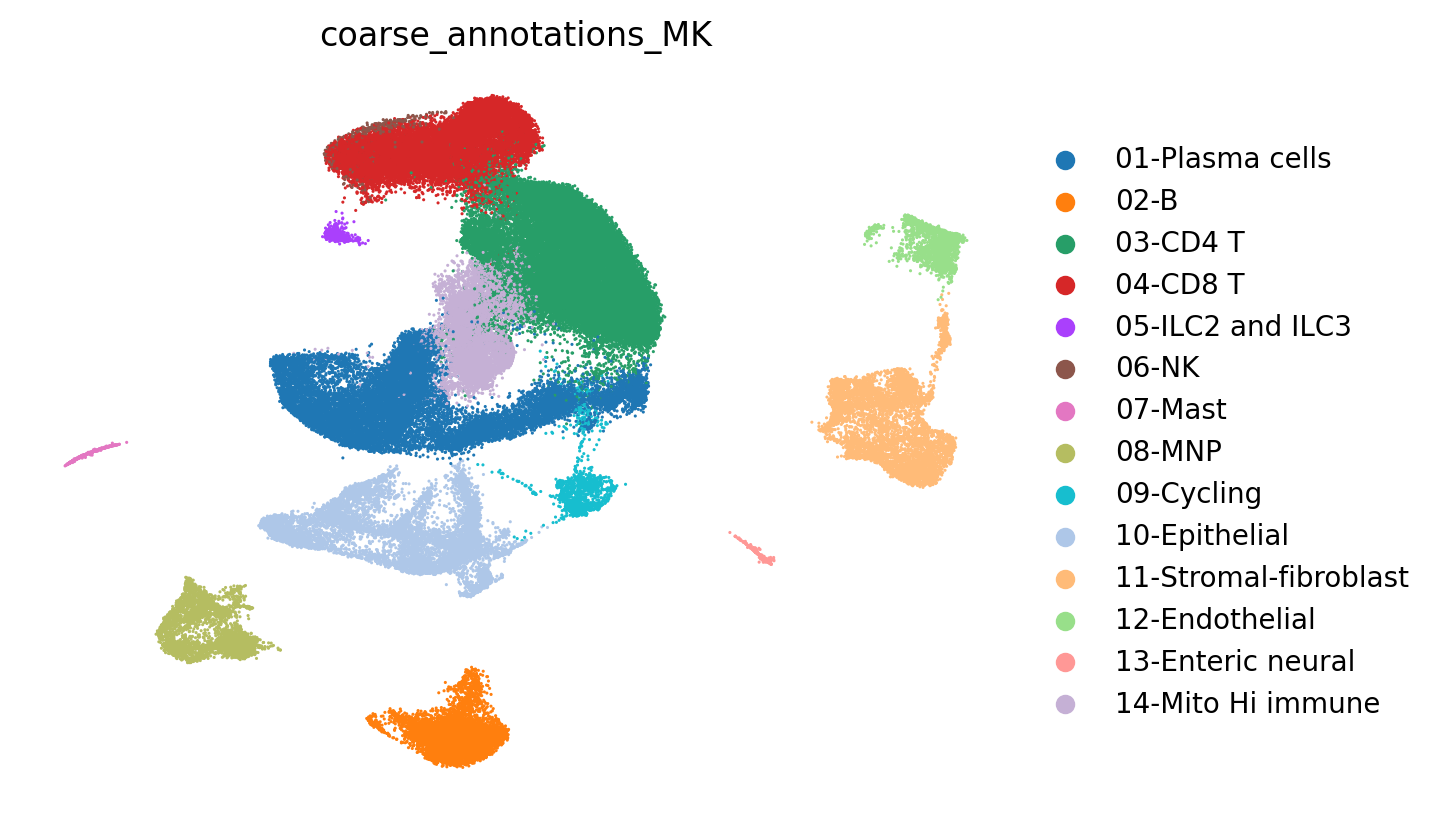

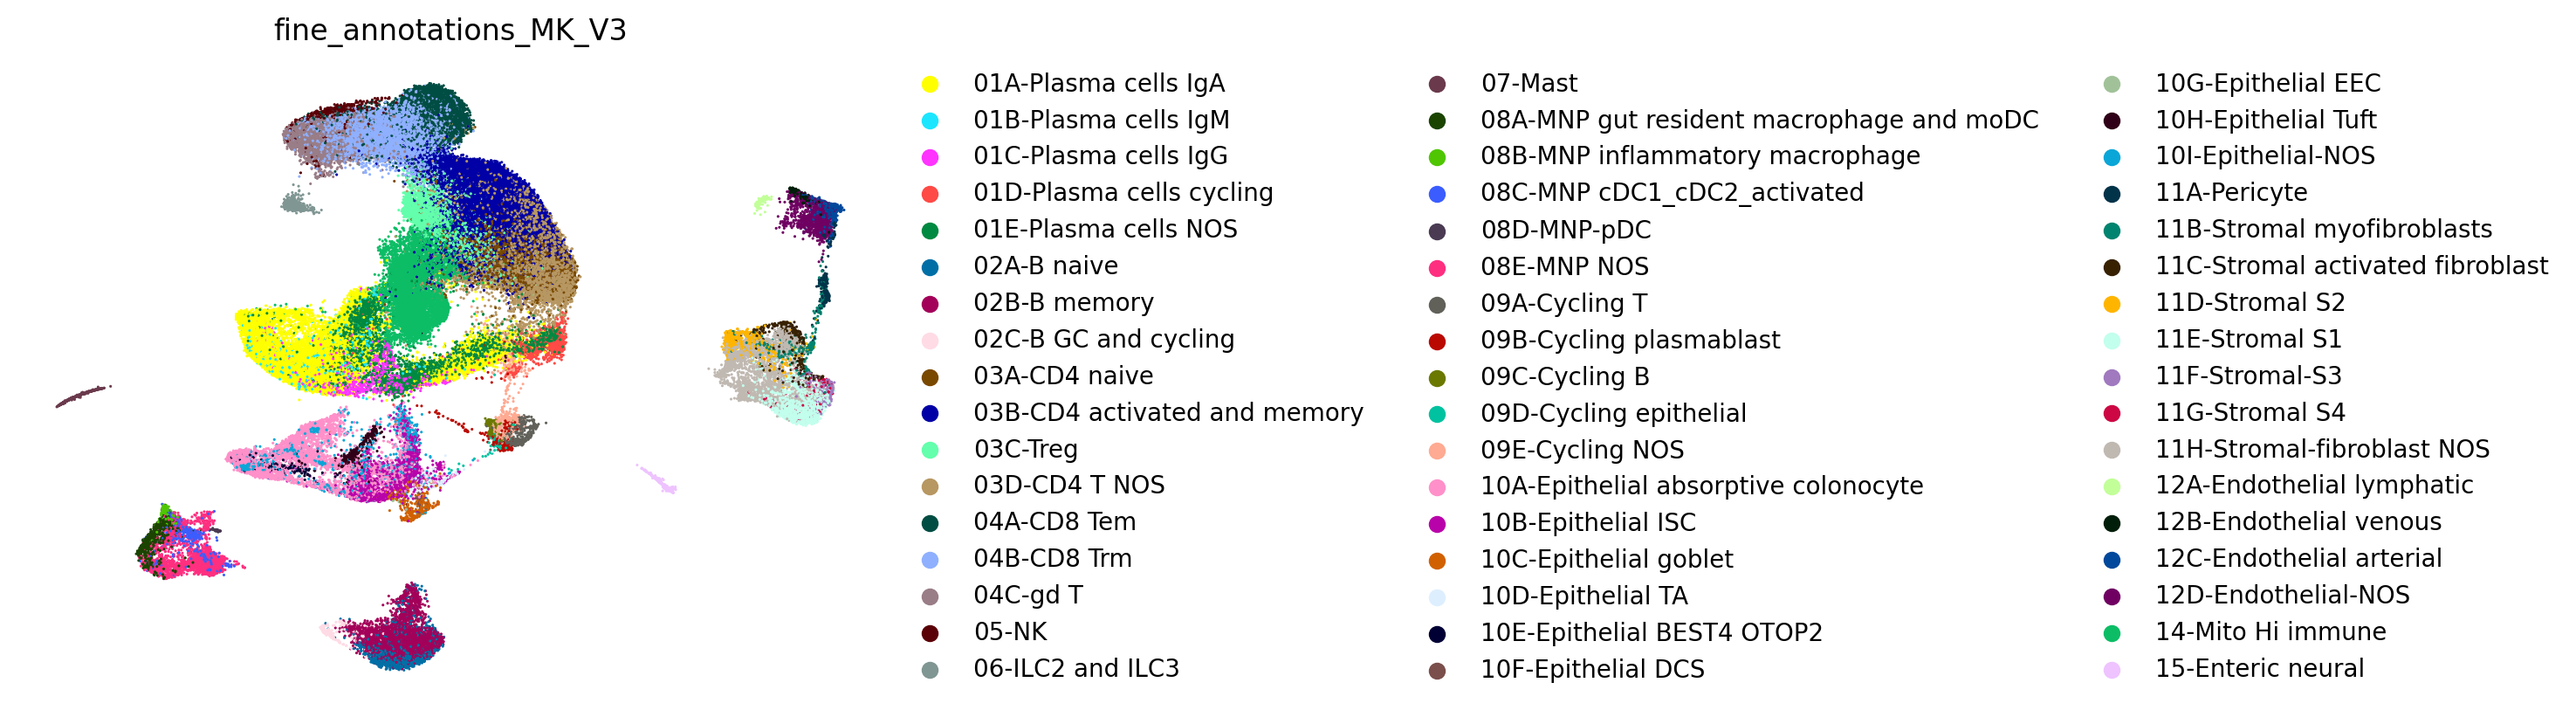

KeyError: 'louvain_res1'

In [17]:
# visualization for different categories, groups, etc.
sc.pl.umap(adata, color=['coarse_annotations_MK'],s=5, frameon=False, ncols=4, vmax='p99', 
           save="_22_5_17_biopsy_coarse.pdf")

sc.pl.umap(adata, color=['fine_annotations_MK_V3'],s=5, frameon=False, ncols=4, vmax='p99',
           save="_22_5_17_biopsy_fine.pdf")

sc.pl.umap(adata, color=['louvain_res1'],s=5, frameon=False, ncols=4, vmax='p99', 
           save="_22_5_17_biopsy_louvain1.pdf")

sc.pl.umap(adata, color=['CoLabs_patient'],s=5, frameon=False, ncols=4, vmax='p99',
           save="_22_5_17_biopsy_patient.pdf")

sc.pl.umap(adata, color=['CoLabs_sample'],s=5, frameon=False, ncols=4, vmax='p99', 
           save="_22_5_17_biopsy_sample.pdf")

sc.pl.umap(adata, color=['colon_biopsy'],s=5, frameon=False, ncols=4, vmax='p99', 
           save="_22_5_17_biopsy_rightleft.pdf")

## Subsetting for ADT object

In [18]:
adata_ADT

AnnData object with n_obs × n_vars = 93900 × 177
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'nCount_ADT', 'nFeature_ADT', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'CoLabs_sample', 'BIOS_ID', 'patient_short', 'coarse_annotations_MK', 'fine_annotations_MK_V3', 'coarse_annotations_MK a4B7 RNA', 'coarse_annotations_MK a4B7 ADT', 'fine_annotations_MK_V3 a4B7 RNA', 'fine_annotations_MK_V3 a4B7 ADT', 'Endoscopic_Severity_V1'
    var: 'assay'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances'

In [7]:
# We'll use CLR-transformation for ADT modality
adata_ADT.X = adata_ADT.layers["counts"].copy()


In [8]:
adata_ADT.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [3., 2., 1., ..., 1., 0., 3.],
        [3., 1., 6., ..., 0., 2., 5.],
        [3., 1., 1., ..., 4., 4., 5.]], dtype=float32)

In [9]:
# CLR-transformation
from muon import prot as pt
pt.pp.clr(adata_ADT)

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/muon/_prot/preproc.py:214: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


In [16]:
adata_ADT.raw = adata_ADT

In [10]:
adata_ADT.X.todense()

matrix([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [1.2643176, 1.0634075, 0.6589421, ..., 0.607337 , 0.       ,
         1.2387868],
        [1.2643176, 0.6668605, 1.8865361, ..., 0.       , 0.9370887,
         1.6264338],
        [1.2643176, 0.6668605, 0.6589421, ..., 1.468369 , 1.412225 ,
         1.6264338]], dtype=float32)

In [17]:
# adata_ADT = adata[:,adata.var["assay"]=='ADT']
adata_ADT_coarse = adata_ADT[adata_ADT.obs['coarse_annotations_MK'].isin(
['01-Plasma cells',
'02-B',
'03-CD4 T',
'04-CD8 T',
'05-ILC2 and ICL3',
'06-NK',
'07-Mast',
'08-MNP',
#'09-Cycling',
'10-Epithelial',
'11-Stromal-fibroblast',
'12-Endothelial',
'13-Enteric neural',
'14-Mito Hi Immune'])]

adata_ADT_B = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['02A-B naive',"02B-B memory",'02C-B GC and cycling'])]
adata_ADT_plasma = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    [#'01A-Plasma cells IgA',
     "01B-Plasma cells IgM",
     '01C-Plasma cells IgG'])]
adata_ADT_CD4 = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['03A-CD4 naive',
     '03B-CD4 activated and memory',
     '03C-Treg'])]
adata_ADT_CD8 = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['04A-CD8 Tem',
     '04B-CD8 Trm',
     '04C-gd T',
     '05-NK'])]
adata_ADT_MNP = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['08A-MNP macrophage',
     '08B-MNP monocyte',
     '08C-MNP mDC',
     '08D-MNP-pDC'])]
adata_ADT_CYCLING = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['09A-Cycling T',
     '09B-Cycling plasmablast',
     '09C-Cycling B'])]#,
     #'09D-Cycling epithelial'])]
adata_ADT_EPITHELIAL = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['10A-Epithelial absorptive colonocyte',
     '10B-Epithelial ISC',
     '10C-Epithelial goblet',
     '10D-Epithelial TA',
     '10E-Epithelial BEST4 OTOP2',
     #'10F-Epithelial DCS',
     '10G-Epithelial EEC',
    '10H-Epithelial Tuft'])]
adata_ADT_STROMAL = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['11A-Pericyte',
     #'11B-Stromal myofibroblasts',
     '11C-Stromal activated fibroblast',
     '11D-Stromal S2',
     '11E-Stromal S1',
     '11F-Stromal-S3',
     '11G-Stromal S4'])]
adata_ADT_ENDOTHELIAL = adata_ADT[adata_ADT.obs["fine_annotations_MK_V4"].isin(
    ['12A-Endothelial lymphatic',
     '12B-Endothelial venous',
     '12C-Endothelial arterial'])]

In [18]:
# performing wilcoxon rank sum tests for all subsetted adata objects
# sc.tl.rank_genes_groups(adata_ADT, groupby='coarse_annotations_MK', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_coarse, groupby='coarse_annotations_MK', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_B, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_plasma, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_CD4, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_CD8, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_MNP, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_CYCLING, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_EPITHELIAL, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_STROMAL, groupby='fine_annotations_MK_V4', method='wilcoxon')
sc.tl.rank_genes_groups(adata_ADT_ENDOTHELIAL, groupby='fine_annotations_MK_V4', method='wilcoxon')

ranking genes


/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by grou

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by grou

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_coarse_annotations_MK']`
categories: 01-Plasma cells, 02-B, 03-CD4 T, etc.
var_group_labels: 01-Plasma cells, 02-B, 03-CD4 T, etc.


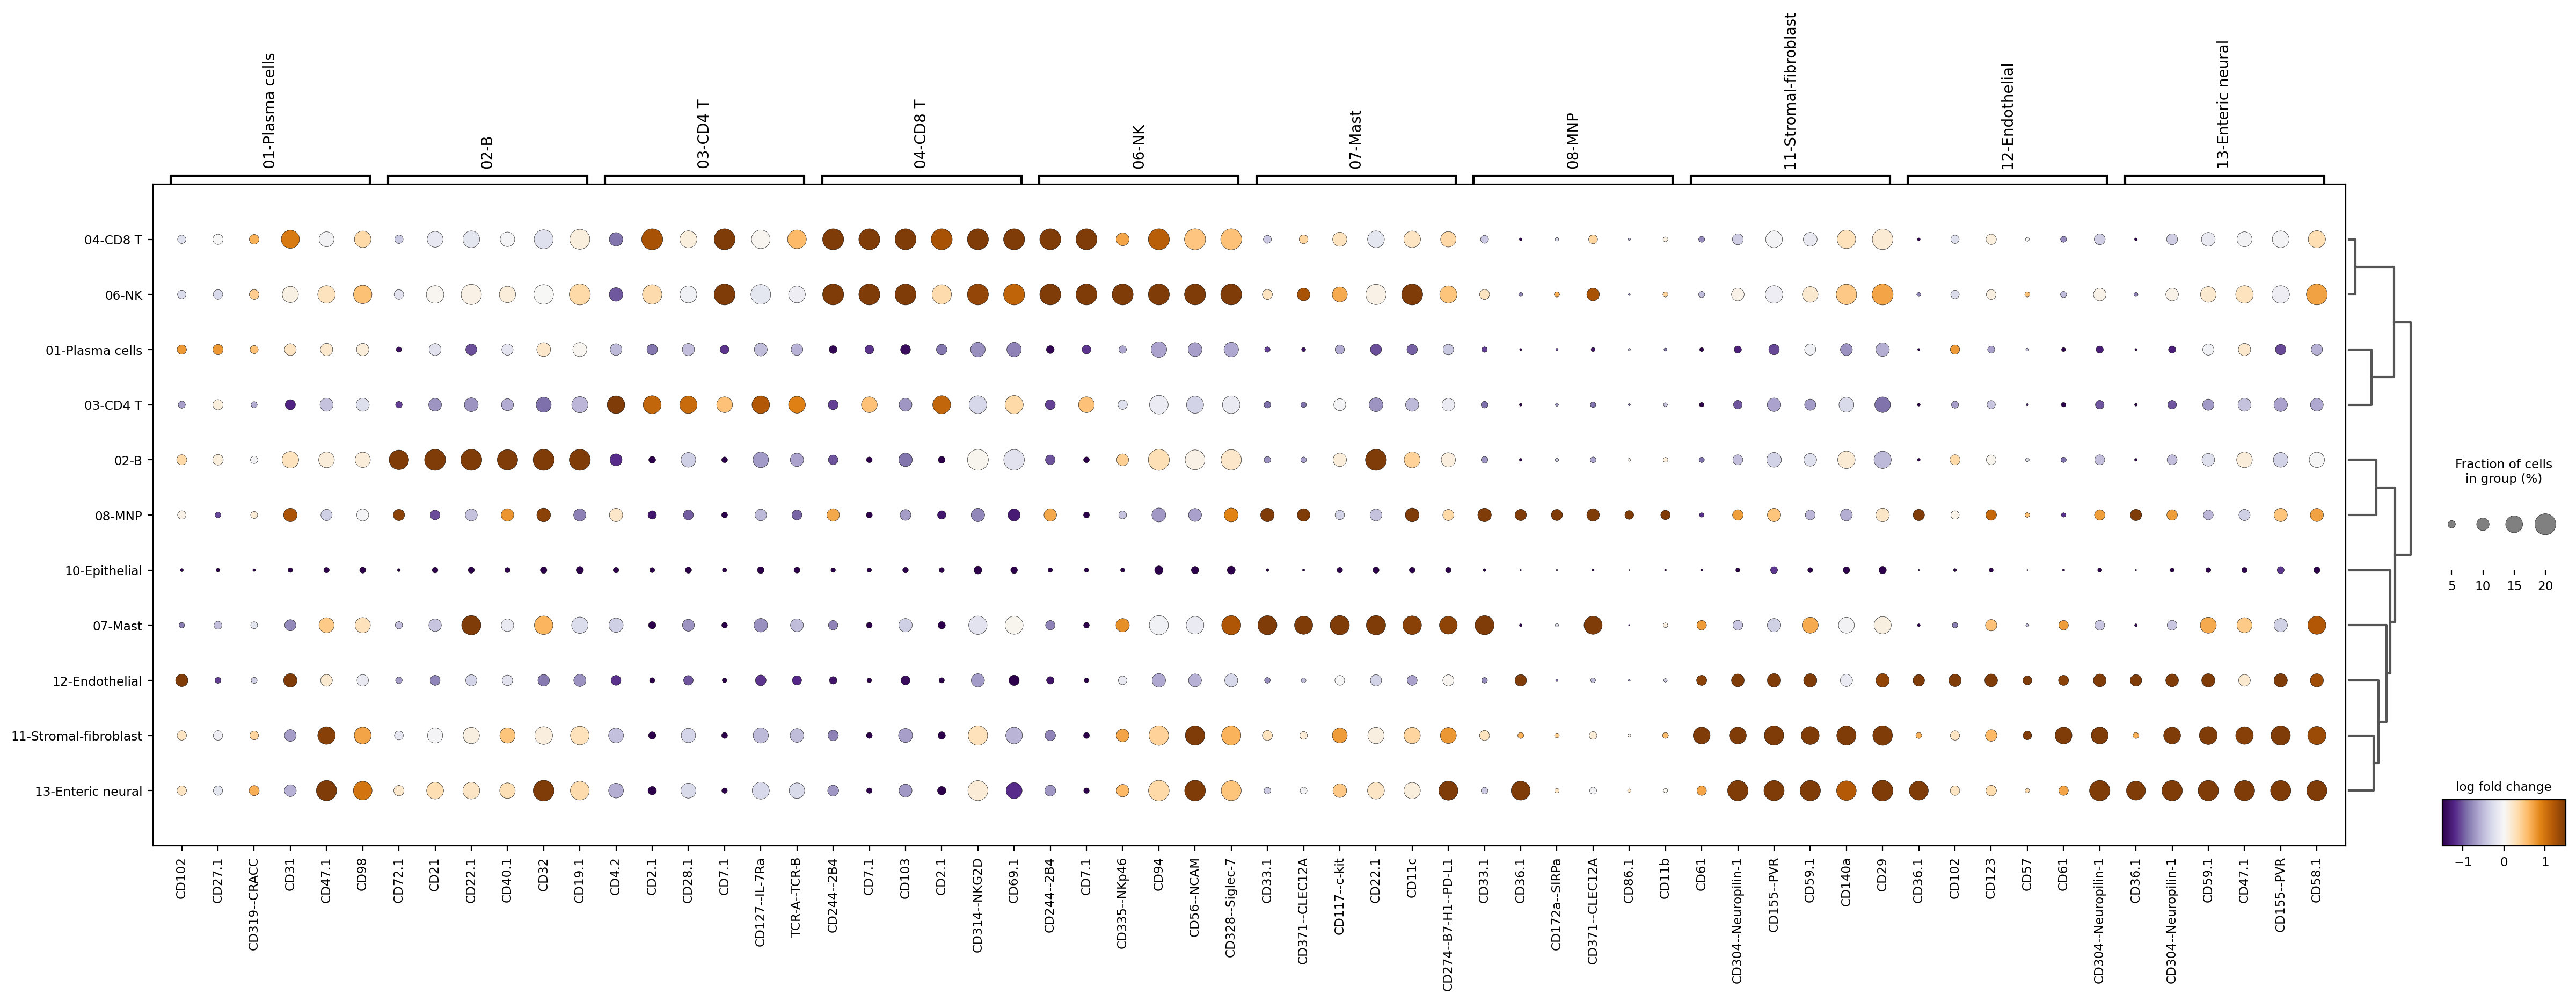

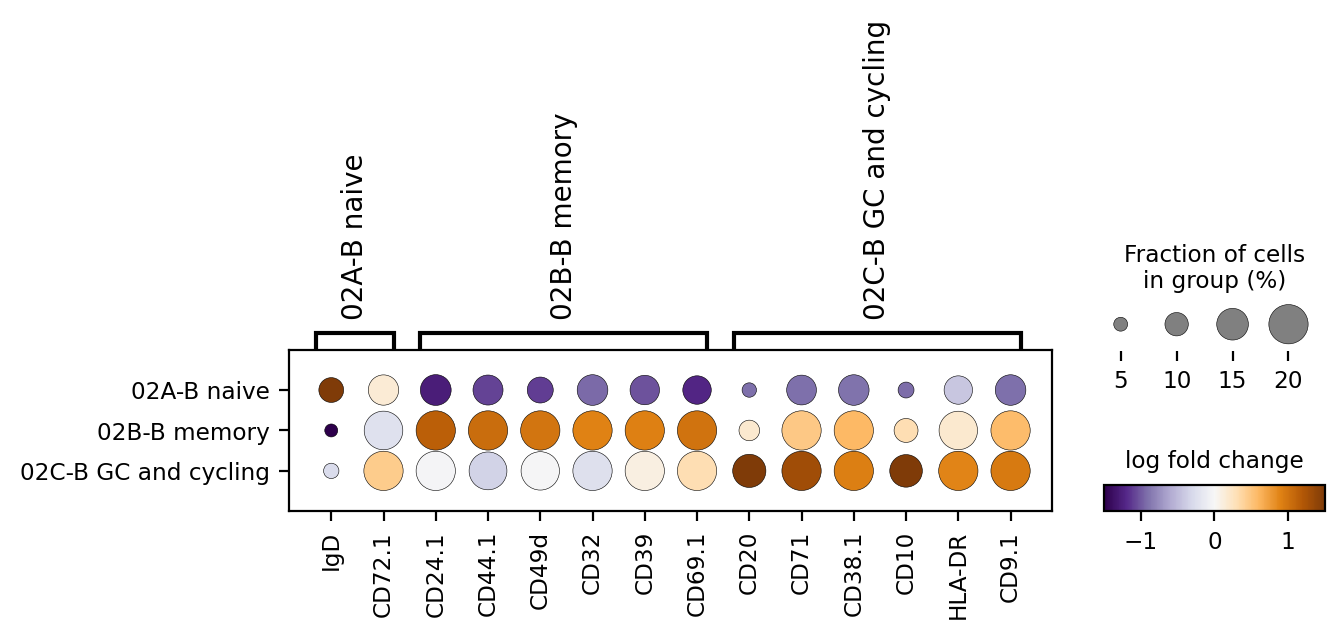

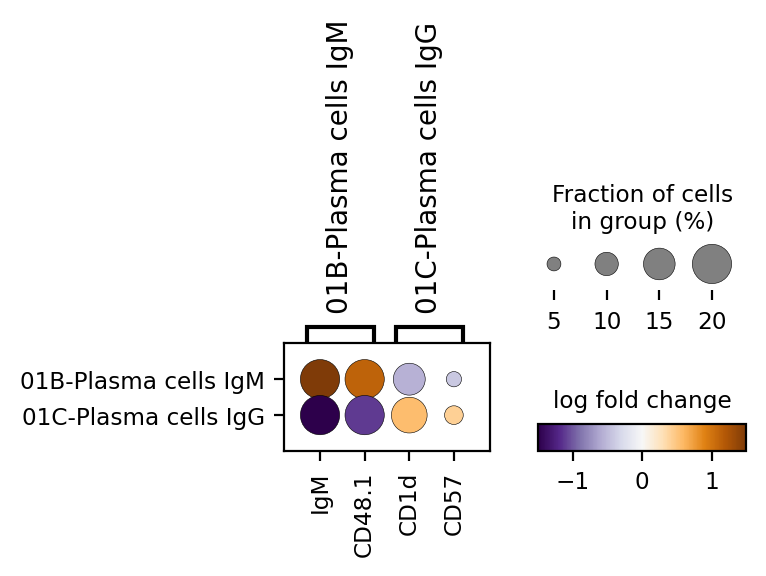

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`


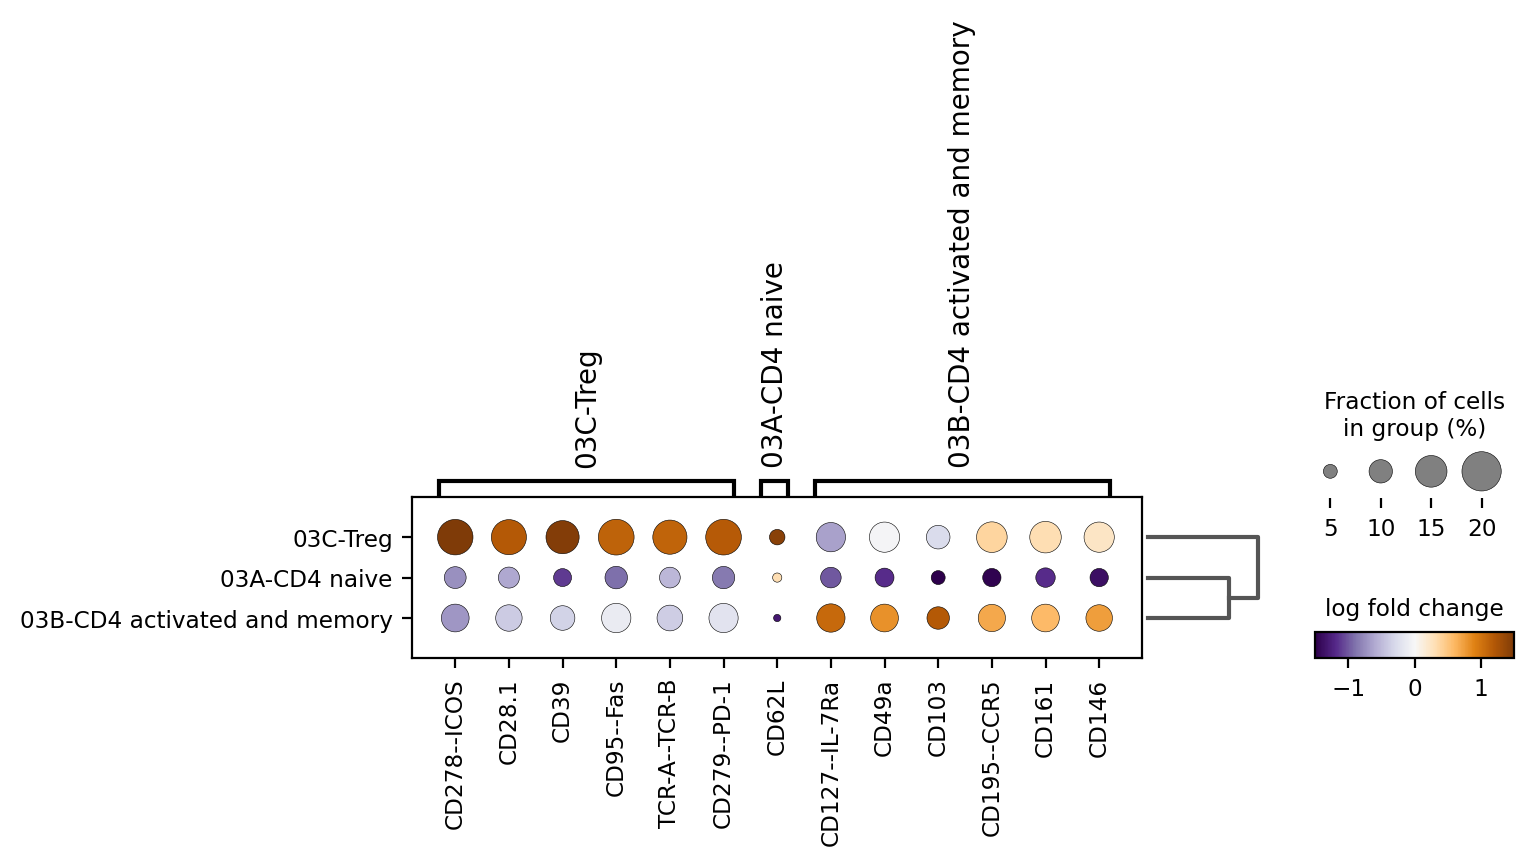

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`


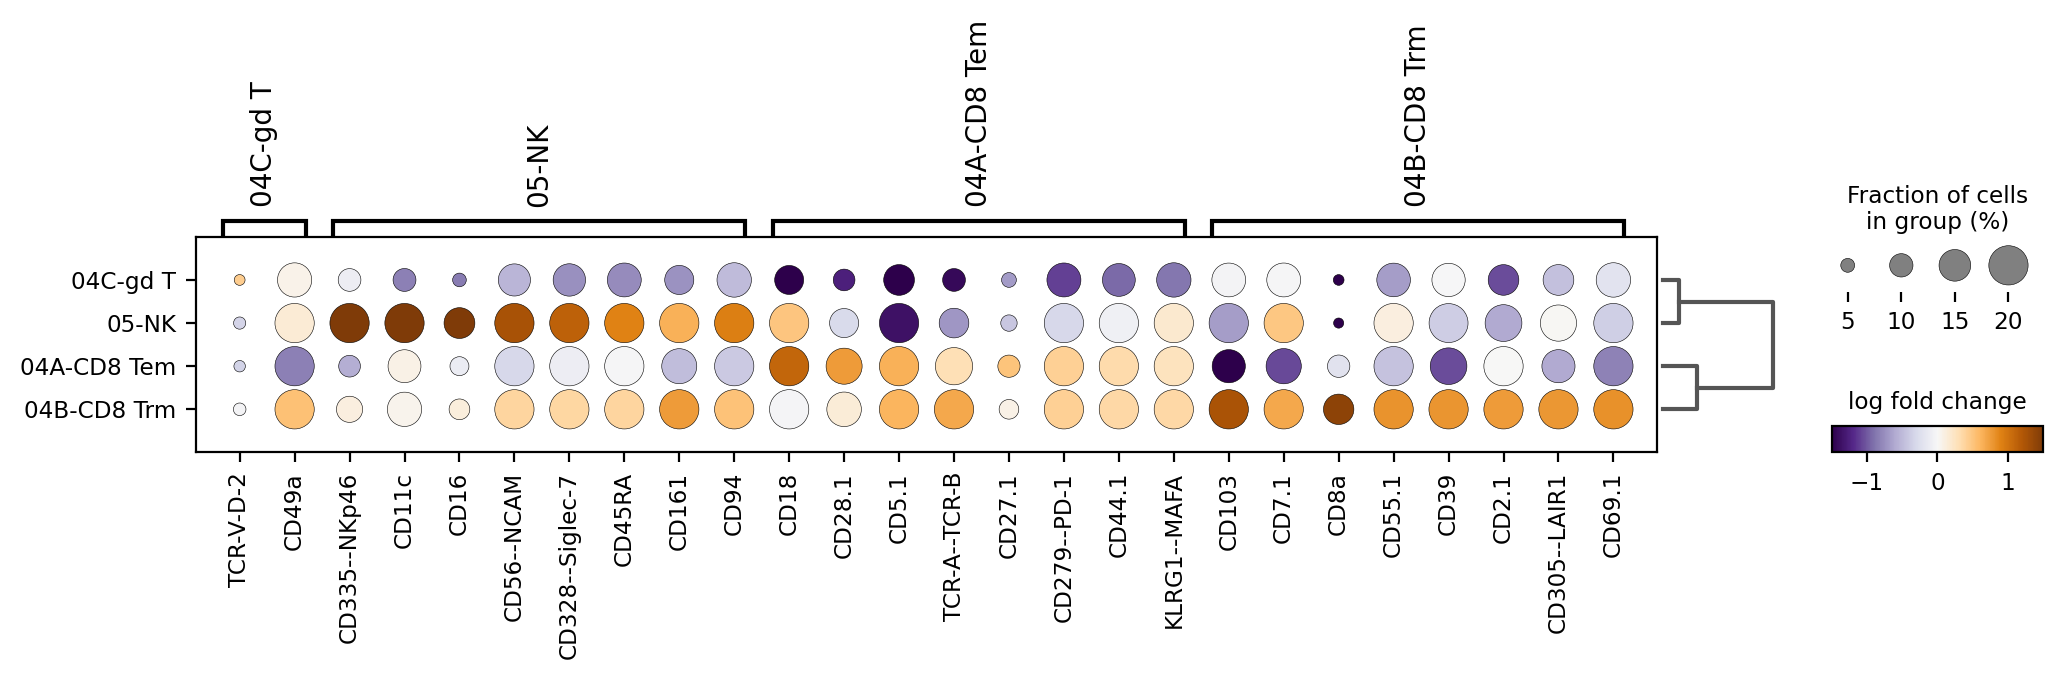

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`


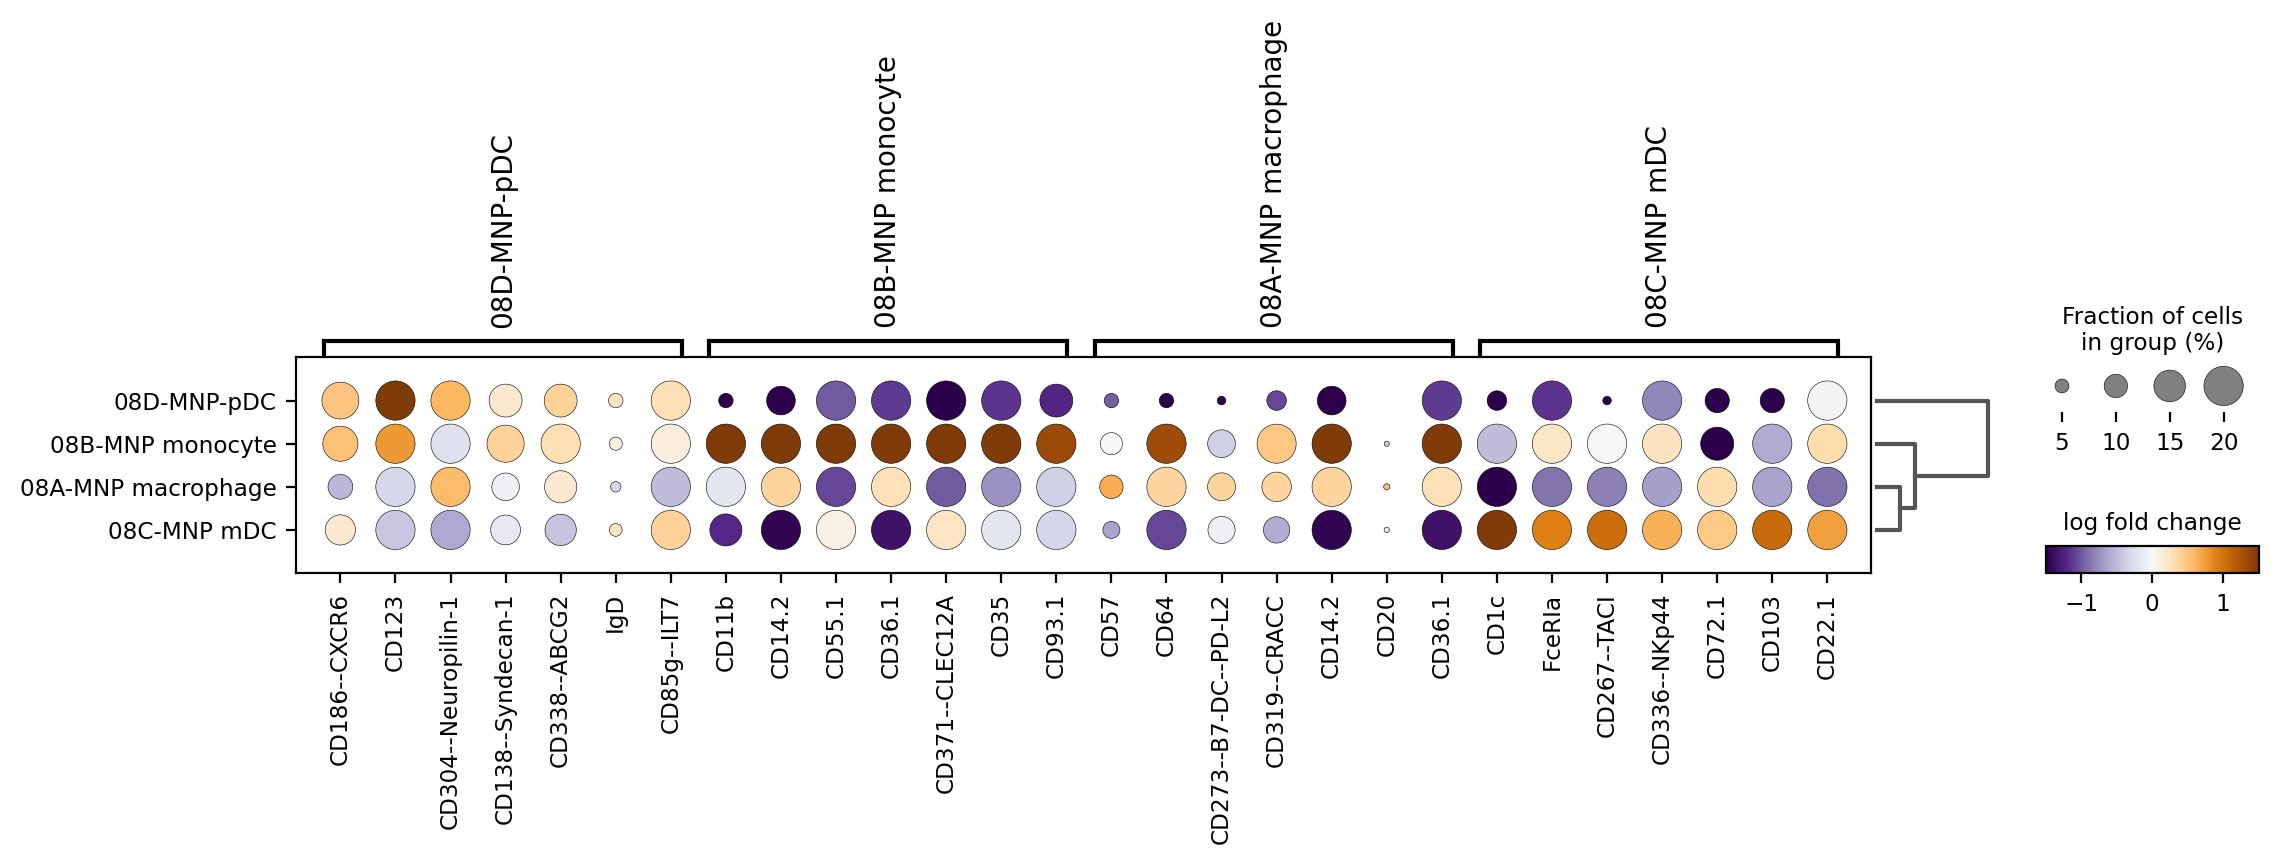

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`


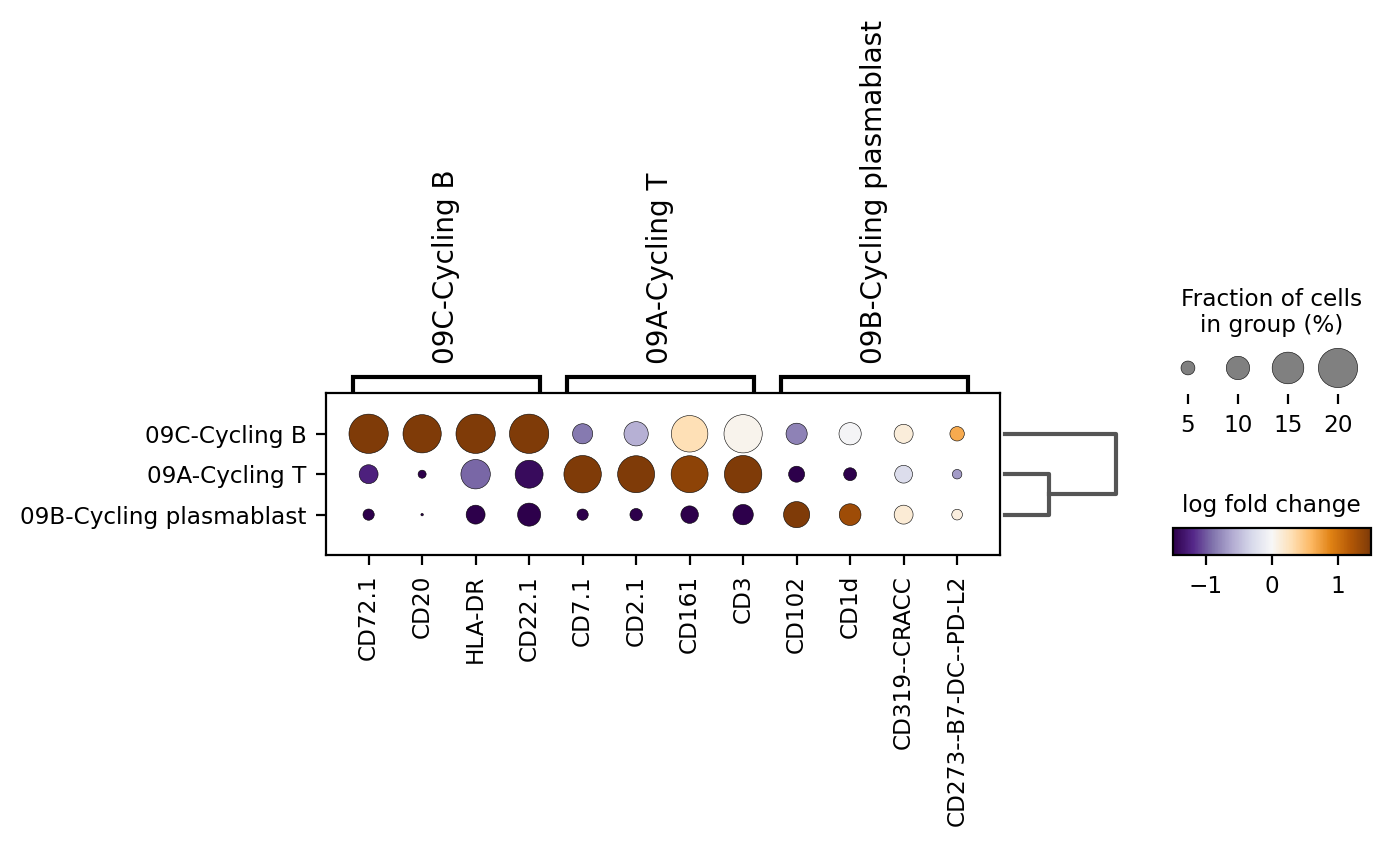

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`
categories: 10A-Epithelial absorptive colonocyte, 10B-Epithelial ISC, 10C-Epithelial goblet, etc.
var_group_labels: 10B-Epithelial ISC, 10C-Epithelial goblet, 10D-Epithelial TA, etc.


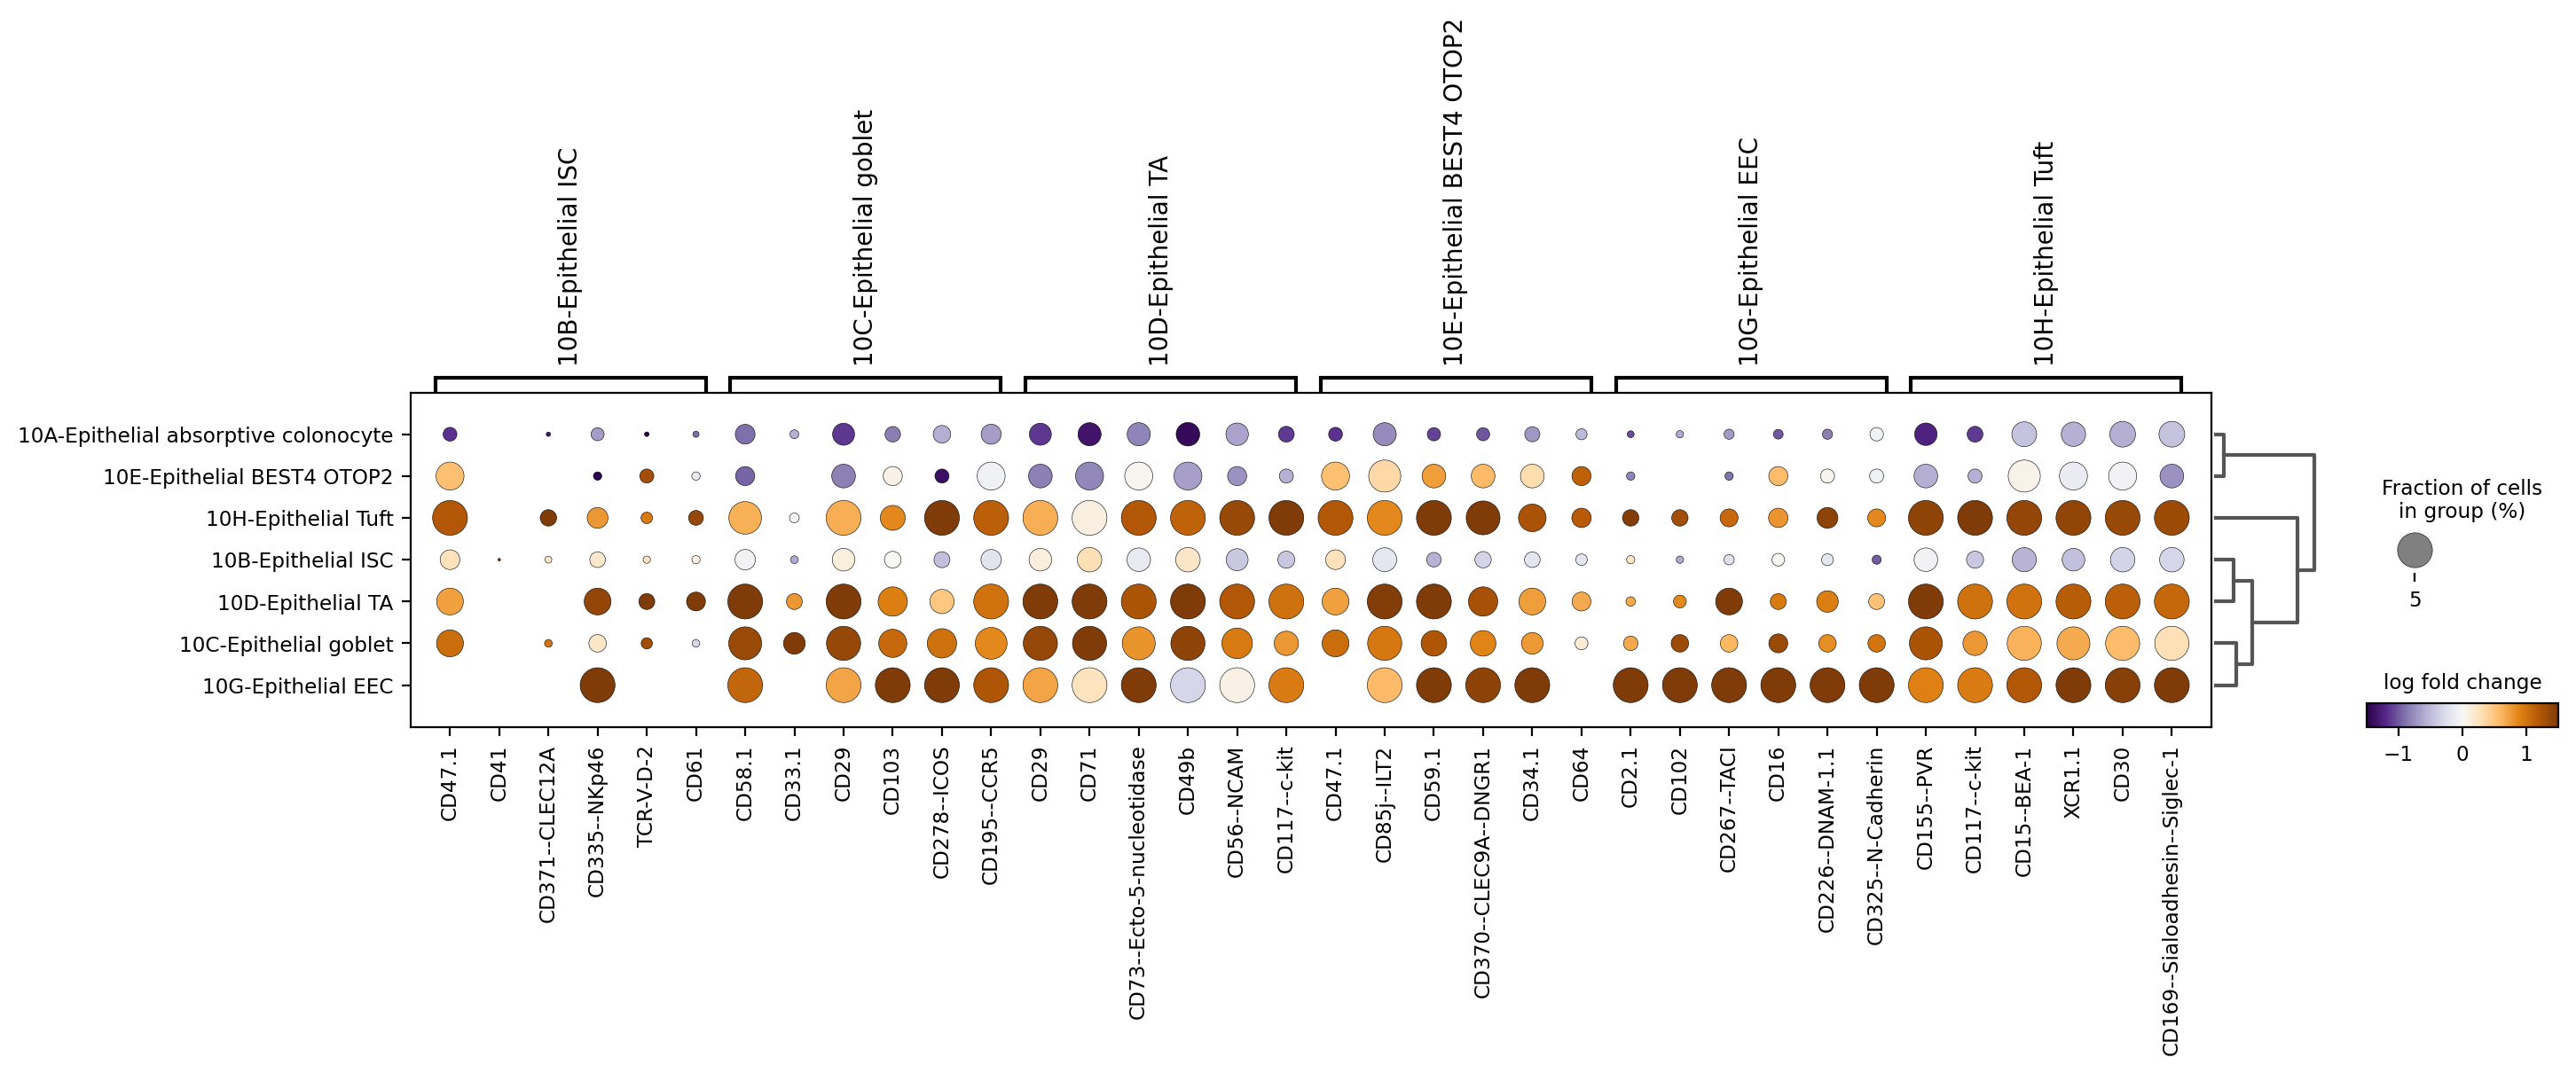

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`


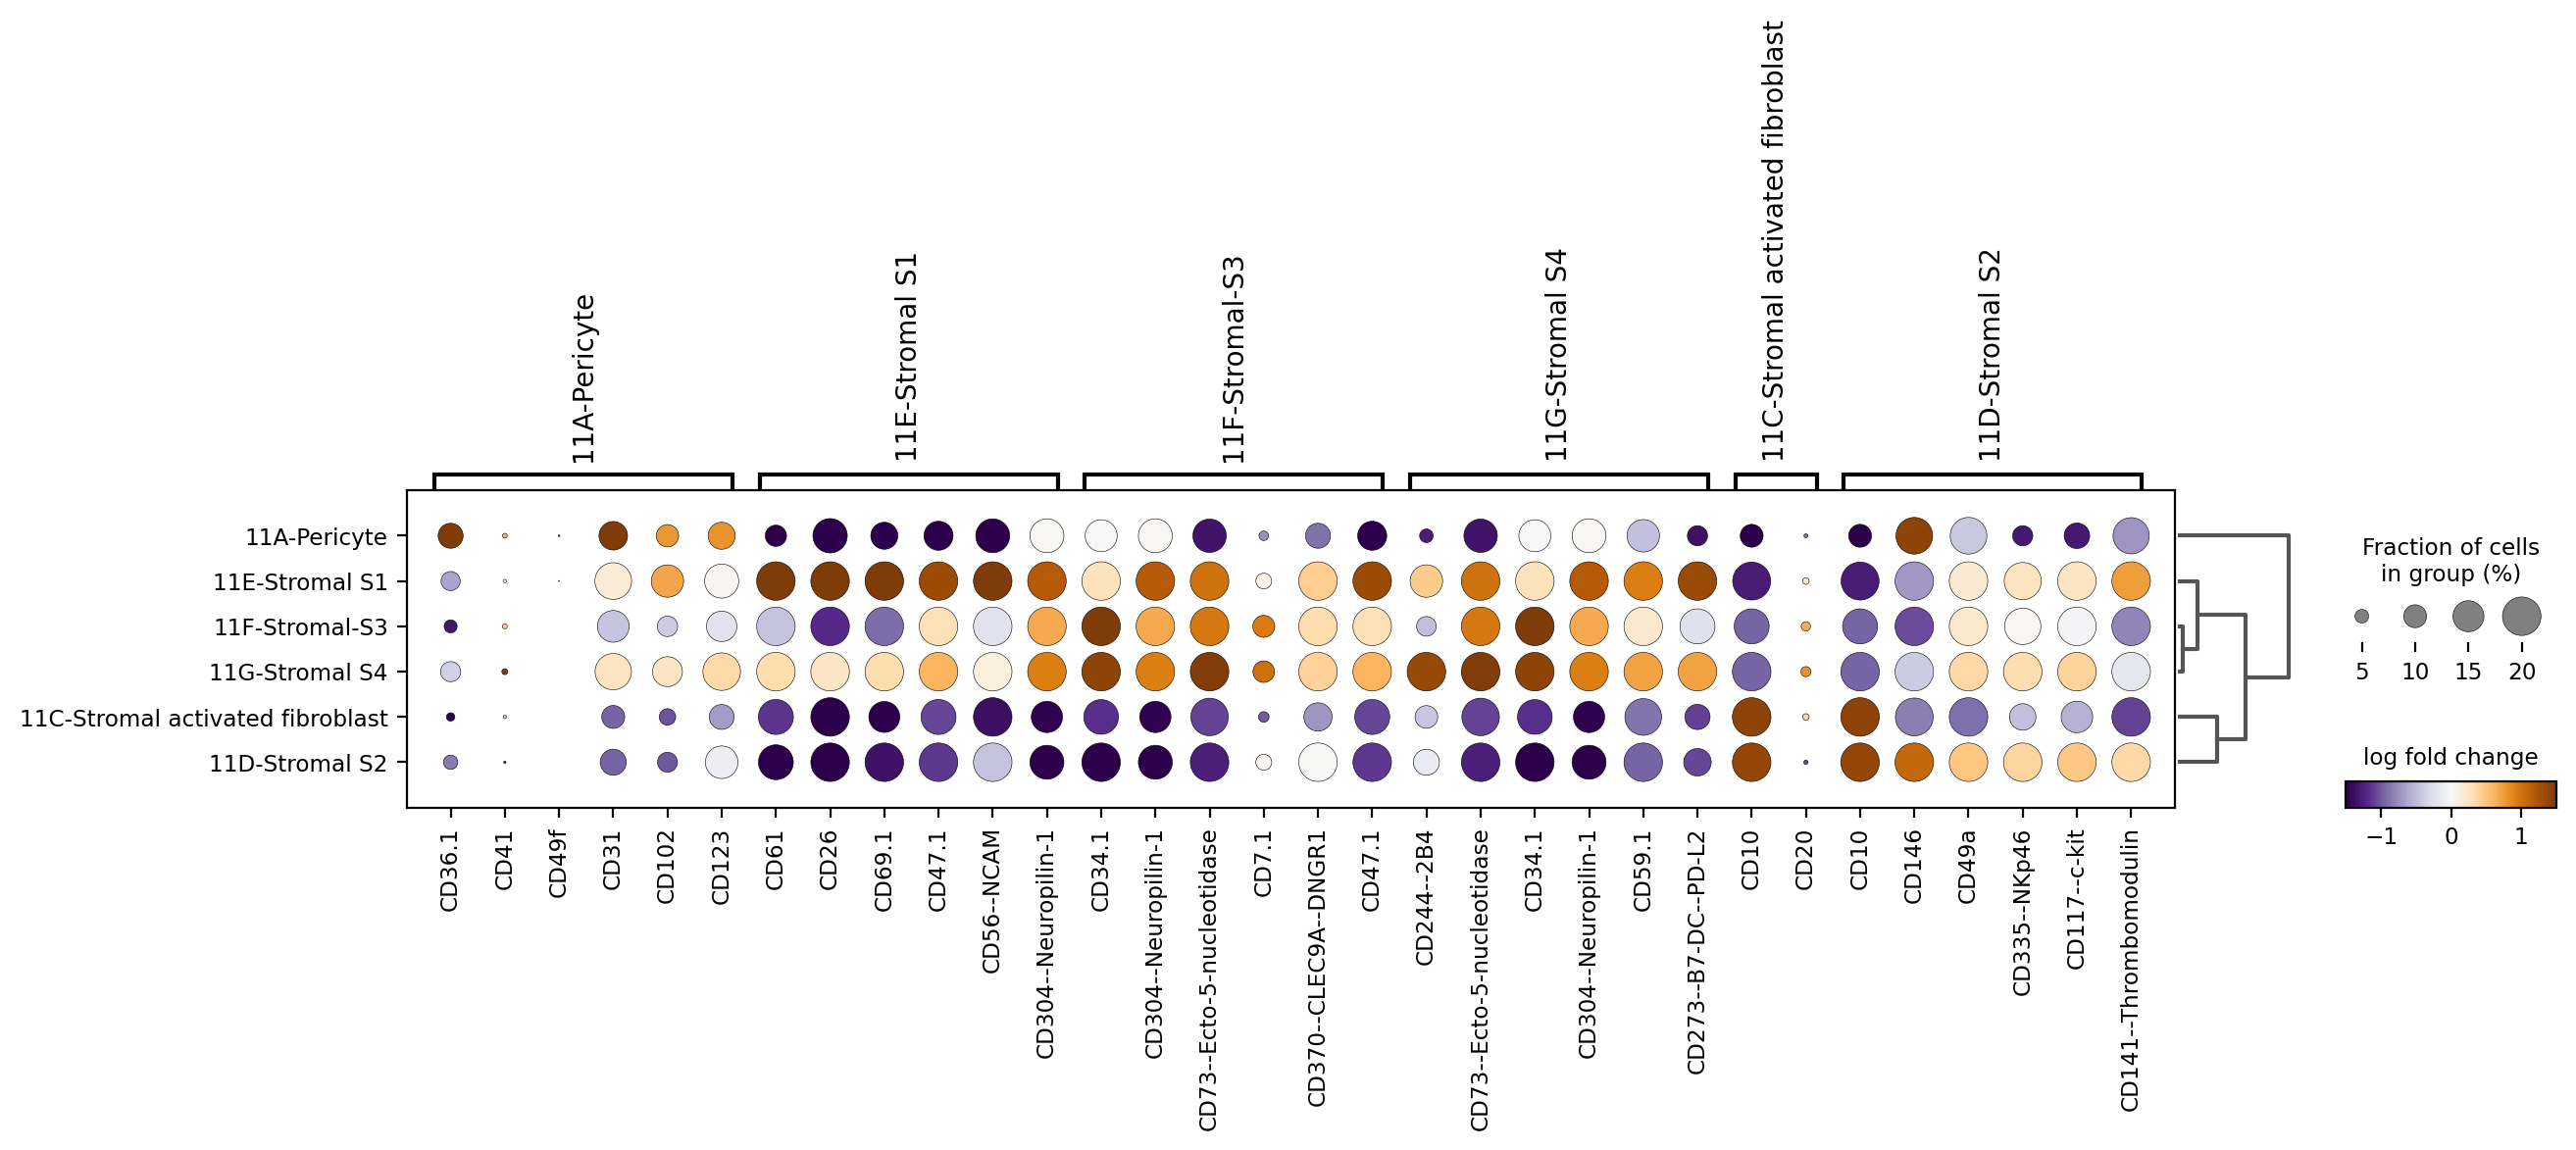

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_fine_annotations_MK_V4']`
categories: 12A-Endothelial lymphatic, 12B-Endothelial venous, 12C-Endothelial arterial
var_group_labels: 12B-Endothelial venous, 12C-Endothelial arterial


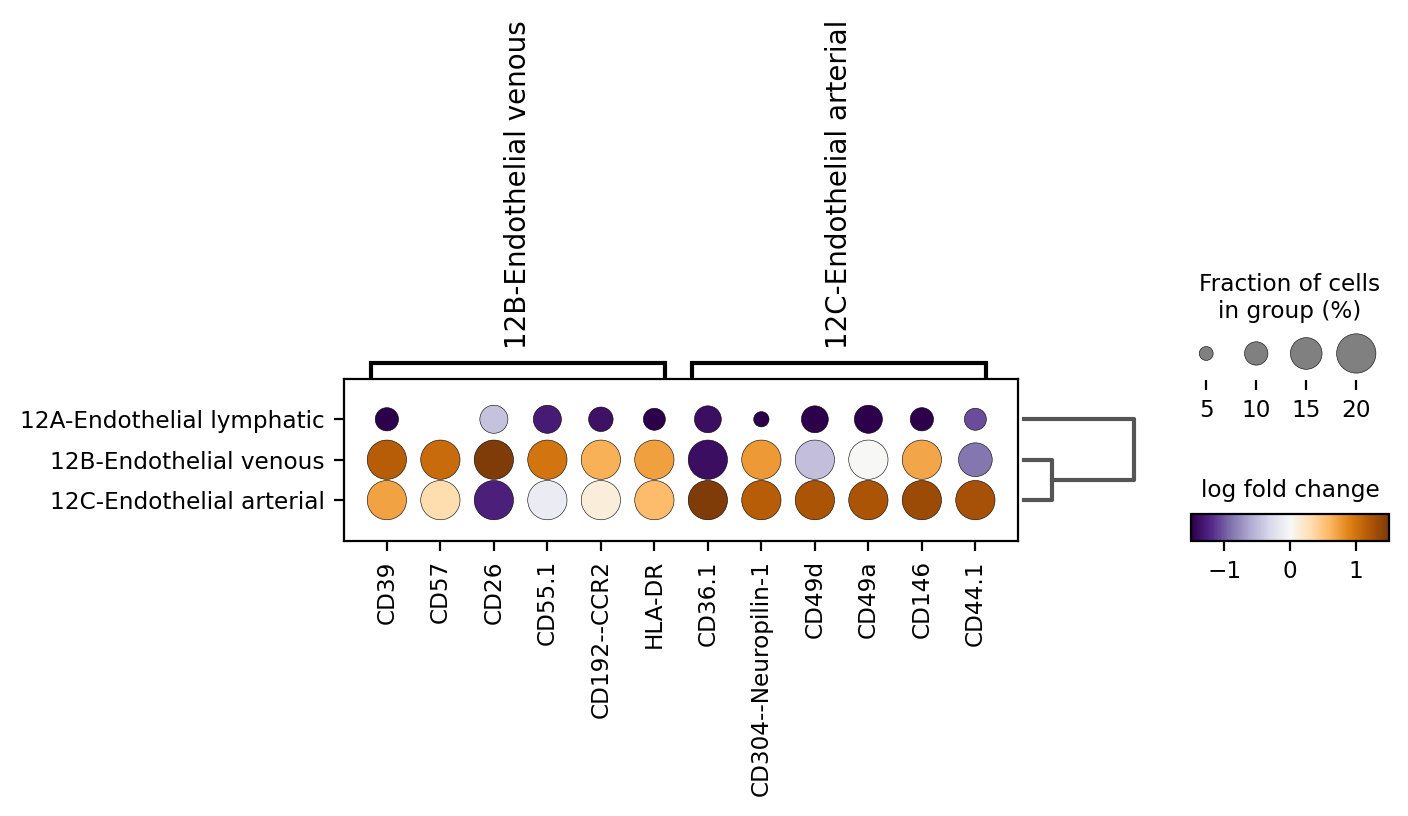

In [19]:
# generating dot plots for all subsetted objects
#sc.pl.rank_genes_groups_dotplot(adata_ADT, n_genes=7, values_to_plot='logfoldchanges', min_logfoldchange=1, 
#                                vmax=3, vmin=-3, cmap='PuOr_r', figsize=(29,8), dot_max=0.2, 
#                                save="22_6_13_biopsy_all_coarse_dot_sized_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_coarse, n_genes=6, values_to_plot='logfoldchanges', min_logfoldchange=0.1, 
                                vmax=1.5, vmin=-1.5, cmap='PuOr_r', figsize=(29,8), dot_max=0.2, 
                                save="23_1_25_biopsy_all_coarse_dot_sized_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_B, n_genes=6, values_to_plot='logfoldchanges', 
                                dot_max=0.2,min_logfoldchange=0.1, vmax=1.5, vmin=-1.5, 
                                cmap='PuOr_r', dendrogram=False, 
                                save="23_1_25_biopsy_B_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_plasma, n_genes=2, values_to_plot='logfoldchanges', 
                                dot_max=0.2, min_logfoldchange=0.01, vmax=1.5, vmin=-1.5, 
                                cmap='PuOr_r', 
                                save="23_1_25_biopsy_plasma_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_CD4, n_genes=6, values_to_plot='logfoldchanges', 
                                dot_max=0.2, min_logfoldchange=0.01, vmax=1.5, vmin=-1.5, 
                                cmap='PuOr_r', 
                                save="23_1_25_biopsy_CD4_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_CD8, n_genes=8, values_to_plot='logfoldchanges',
                                dot_max=0.2, min_logfoldchange=0, vmax=1.5, vmin=-1.5, cmap='PuOr_r', 
                                save="23_1_25_biopsy_CD8_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_MNP, n_genes=7, values_to_plot='logfoldchanges', 
                                dot_max=0.2, min_logfoldchange=0.1, vmax=1.5, vmin=-1.5, cmap='PuOr_r', 
                                save="23_1_25_biopsy_MNP_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_CYCLING, n_genes=4, values_to_plot='logfoldchanges', 
                                dot_max=0.2, min_logfoldchange=0.1, vmax=1.5, vmin=-1.5, cmap='PuOr_r', 
                                save="23_1_25_biopsy_cycling_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_EPITHELIAL, n_genes=6, values_to_plot='logfoldchanges', 
                                dot_max=0.05, min_logfoldchange=0.1, vmax=1.5, vmin=-1.5, cmap='PuOr_r', 
                                save="23_1_25_biopsy_EPITHELIAL_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_STROMAL, n_genes=6, values_to_plot='logfoldchanges', 
                                dot_max=0.2, min_logfoldchange=0.1, vmax=1.5, vmin=-1.5, cmap='PuOr_r', 
                                save="23_1_25_biopsy_STROMAL_fine_dot_ADT.pdf")

sc.pl.rank_genes_groups_dotplot(adata_ADT_ENDOTHELIAL, n_genes=6, values_to_plot='logfoldchanges', 
                                dot_max=0.2, min_logfoldchange=0.1, vmax=1.5, vmin=-1.5, cmap='PuOr_r', 
                                save="23_1_25_biopsy_ENDOTHELIAL_fine_dot_ADT.pdf")

## saving the ADT var names as dataframe (.csv)

In [51]:
list_ADT_markers = adata_ADT.var_names.to_list()
list_ADT_markers

['B7-H4',
 'C5L2',
 'CD10',
 'CD102',
 'CD103',
 'CD105',
 'CD107a--LAMP-1',
 'CD112--Nectin-2',
 'CD115--CSF-1R',
 'CD117--c-kit',
 'CD119--IFN-G-R-A-chain',
 'CD11b',
 'CD11c',
 'CD123',
 'CD127--IL-7Ra',
 'CD134--OX40',
 'CD135',
 'CD137',
 'CD137L--4-1BB-Ligand',
 'CD138--Syndecan-1',
 'CD14.2',
 'CD140a',
 'CD140b',
 'CD141--Thrombomodulin',
 'CD144--VE-cadherin',
 'CD146',
 'CD15--BEA-1',
 'CD152',
 'CD154',
 'CD155--PVR',
 'CD158--KIR2DL1--KIR2DS1--KIR2DS3--KIR2DS5',
 'CD158b--KIR2DL2--KIR2DL3--NKAT2',
 'CD158e1--KIR3DL1--NKB1',
 'CD158f--KIR2DL5',
 'CD16',
 'CD161',
 'CD163.1',
 'CD169--Sialoadhesin--Siglec-1',
 'CD172a--SIRPa',
 'CD178--FasL',
 'CD18',
 'CD183--CXCR3',
 'CD184--CXCR4',
 'CD185--CXCR5',
 'CD186--CXCR6',
 'CD19.1',
 'CD192--CCR2',
 'CD193--CCR3',
 'CD194--CCR4',
 'CD195--CCR5',
 'CD196--CCR6',
 'CD197--CCR7',
 'CD1a',
 'CD1c',
 'CD1d',
 'CD2.1',
 'CD20',
 'CD202b--Tie2--Tek',
 'CD21',
 'CD22.1',
 'CD223--LAG-3',
 'CD226--DNAM-1.1',
 'CD23',
 'CD24.1',
 'CD244--2

In [47]:
# initialize the dataframe
df_ADT_markers = pd.DataFrame(list_ADT_markers)

df_ADT_markers

0
0           B7-H4
1            C5L2
2            CD10
3           CD102
4           CD103
..            ...
171     TCR-V-G-9
172  TIGIT--VSTM3
173         Tim-4
174         TSLPR
175        XCR1.1

[176 rows x 1 columns]

In [23]:
adata_RNA.write_h5ad('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/Cellxgene/MK_version/22_6_13_biopsy_RNA_Wilcoxon.h5ad')

In [20]:
adata_ADT.write_h5ad('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/Cellxgene/MK_version/22_6_13_biopsy_ADT.h5ad')

## Concatenate the RNA and ADT objects


In [26]:
import anndata as ad
adata_joint = ad.concat([adata_RNA, adata_ADT], axis=1, merge="first")
adata_joint

AnnData object with n_obs × n_vars = 93900 × 28815
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'SAMPLE.by.SNPs', 'nCount_SCT', 'nFeature_SCT', 'DF.DROPLET.TYPE', 'LIBRARY', 'nCount_ADT', 'nFeature_ADT', 'CoLabs_ID', 'CoLabs_patient', 'colon_biopsy', 'condition', 'LIBRARY.TYPE', 'CoLabs_sample', 'BIOS_ID', 'patient_short', 'coarse_annotations_MK', 'coarse_annotations_MK a4B7 RNA', 'coarse_annotations_MK a4B7 ADT', 'Endoscopic_Severity_V1', 'fine_annotations_MK_V4'
    var: 'assay'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances'

In [27]:
adata_joint.write_h5ad("/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/Cellxgene/MK_version/22_6_13_biopsy_RNA_ADT_joint.h5ad")

## Cell type abundances

In [18]:
list_cell_types = adata.obs["fine_annotations_MK_V3 a4B7 RNA"].unique().to_list()
list_cell_types.sort()
list_cell_types

['01A-Plasma cells IgA',
 '01B-Plasma cells IgM',
 '01C-Plasma cells IgG',
 '01D-Plasma cells cycling',
 '01E-Plasma cells NOS',
 '02A-B naive',
 '02A-B naive a4B7',
 '02B-B memory',
 '02B-B memory a4B7',
 '02C-B GC and cycling',
 '02C-B GC and cycling a4B7',
 '03A-CD4 naive',
 '03A-CD4 naive a4B7',
 '03B-CD4 activated and memory',
 '03B-CD4 activated and memory a4B7',
 '03C-Treg',
 '03C-Treg a4B7',
 '03D-CD4 T NOS',
 '03D-CD4 T NOS a4B7',
 '04A-CD8 Tem',
 '04A-CD8 Tem a4B7',
 '04B-CD8 Trm',
 '04B-CD8 Trm a4B7',
 '04C-gd T',
 '04C-gd T a4B7',
 '05-NK',
 '05-NK a4B7',
 '06-ILC2 and ILC3',
 '06-ILC2 and ILC3 a4B7',
 '07-Mast',
 '07-Mast a4B7',
 '08A-MNP gut resident macrophage and moDC',
 '08A-MNP gut resident macrophage and moDC a4B7',
 '08B-MNP inflammatory macrophage',
 '08B-MNP inflammatory macrophage a4B7',
 '08C-MNP cDC1_cDC2_activated',
 '08C-MNP cDc1_cDC2_activated a4B7',
 '08D-MNP-pDC',
 '08D-MNP-pDC a4B7',
 '08E-MNP NOS',
 '08E-MNP NOS a4B7',
 '09A-Cycling T',
 '09A-Cycling T a

In [20]:
list_patient_IDs = adata.obs["CoLabs_sample"].unique().to_list()
list_patient_IDs.sort()
list_patient_IDs

['XAUT1-HS1-CLL1',
 'XAUT1-HS1-CLR1',
 'XAUT1-HS10-CLR1',
 'XAUT1-HS11-CLL1',
 'XAUT1-HS11-CLR1',
 'XAUT1-HS12-CLR1',
 'XAUT1-HS2-CLL1',
 'XAUT1-HS2-CLR1',
 'XAUT1-HS3-CLL1',
 'XAUT1-HS3-CLR1',
 'XAUT1-HS4-CLL1',
 'XAUT1-HS4-CLR1',
 'XAUT1-HS5-CLL1',
 'XAUT1-HS5-CLR1',
 'XAUT1-HS6-CLL1',
 'XAUT1-HS6-CLR1',
 'XAUT1-HS7-CLL1',
 'XAUT1-HS7-CLR1',
 'XAUT1-HS8-CLL1',
 'XAUT1-HS9-CLL1',
 'XAUT1-HS9-CLR1']

In [21]:
# initialize the dataframe
cell_type_abundances = pd.DataFrame(np.zeros((len(list_patient_IDs), len(list_cell_types))),dtype = np.int16,
                                    index = list_patient_IDs,
                                    columns = list_cell_types)

cell_type_abundances

01A-Plasma cells IgA  01B-Plasma cells IgM  \
XAUT1-HS1-CLL1                      0                     0   
XAUT1-HS1-CLR1                      0                     0   
XAUT1-HS10-CLR1                     0                     0   
XAUT1-HS11-CLL1                     0                     0   
XAUT1-HS11-CLR1                     0                     0   
XAUT1-HS12-CLR1                     0                     0   
XAUT1-HS2-CLL1                      0                     0   
XAUT1-HS2-CLR1                      0                     0   
XAUT1-HS3-CLL1                      0                     0   
XAUT1-HS3-CLR1                      0                     0   
XAUT1-HS4-CLL1                      0                     0   
XAUT1-HS4-CLR1                      0                     0   
XAUT1-HS5-CLL1                      0                     0   
XAUT1-HS5-CLR1                      0                     0   
XAUT1-HS6-CLL1                      0                     0   
XAUT1-HS6-CLR1                      0                     0   
XAUT1-HS7-CLL1                      0                     0   
XAUT1-HS7-CLR1                      0                     0   
XAUT1-HS8-CLL1                      0                     0   
XAUT1-HS9-CLL1                      0                     0   
XAUT1-HS9-CLR1                      0                     0   

                 01C-Plasma cells IgG  01D-Plasma cells cycling  \
XAUT1-HS1-CLL1                      0                         0   
XAUT1-HS1-CLR1                      0                         0   
XAUT1-HS10-CLR1                     0                         0   
XAUT1-HS11-CLL1                     0                         0   
XAUT1-HS11-CLR1                     0                         0   
XAUT1-HS12-CLR1                     0                         0   
XAUT1-HS2-CLL1                      0                         0   
XAUT1-HS2-CLR1                      0                         0   
XAUT1-HS3-CLL1                      0                         0   
XAUT1-HS3-CLR1                      0                         0   
XAUT1-HS4-CLL1                      0                         0   
XAUT1-HS4-CLR1                      0                         0   
XAUT1-HS5-CLL1                      0                         0   
XAUT1-HS5-CLR1                      0                         0   
XAUT1-HS6-CLL1                      0                         0   
XAUT1-HS6-CLR1                      0                         0   
XAUT1-HS7-CLL1                      0                         0   
XAUT1-HS7-CLR1                      0                         0   
XAUT1-HS8-CLL1                      0                         0   
XAUT1-HS9-CLL1                      0                         0   
XAUT1-HS9-CLR1                      0                         0   

                 01E-Plasma cells NOS  02A-B naive  02A-B naive a4B7  \
XAUT1-HS1-CLL1                      0            0                 0   
XAUT1-HS1-CLR1                      0            0                 0   
XAUT1-HS10-CLR1                     0            0                 0   
XAUT1-HS11-CLL1                     0            0                 0   
XAUT1-HS11-CLR1                     0            0                 0   
XAUT1-HS12-CLR1                     0            0                 0   
XAUT1-HS2-CLL1                      0            0                 0   
XAUT1-HS2-CLR1                      0            0                 0   
XAUT1-HS3-CLL1                      0            0                 0   
XAUT1-HS3-CLR1                      0            0                 0   
XAUT1-HS4-CLL1                      0            0                 0   
XAUT1-HS4-CLR1                      0            0                 0   
XAUT1-HS5-CLL1                      0            0                 0   
XAUT1-HS5-CLR1                      0            0                 0   
XAUT1-HS6-CLL1                      0            0                 0   
XAU

In [22]:
# calculate the number of cells in each cell-type for each patient, then fill in the dataframe
for i in range(0,len(list_patient_IDs)):
    for j in range(0,len(list_cell_types)):
        patient_ID = list_patient_IDs[i]
        cell_type = list_cell_types[j]
        
        num_cells = len(adata[(adata.obs["CoLabs_sample"]==patient_ID) & (adata.obs["fine_annotations_MK_V3 a4B7 RNA"]==cell_type)])
        
        cell_type_abundances.loc[patient_ID,cell_type] = num_cells

In [23]:
# check the dataframe
cell_type_abundances

01A-Plasma cells IgA  01B-Plasma cells IgM  \
XAUT1-HS1-CLL1                    294                     3   
XAUT1-HS1-CLR1                    933                    24   
XAUT1-HS10-CLR1                    65                     3   
XAUT1-HS11-CLL1                    65                     0   
XAUT1-HS11-CLR1                   262                    15   
XAUT1-HS12-CLR1                   785                    10   
XAUT1-HS2-CLL1                    503                    25   
XAUT1-HS2-CLR1                    489                    24   
XAUT1-HS3-CLL1                    760                    21   
XAUT1-HS3-CLR1                    845                    66   
XAUT1-HS4-CLL1                    460                    20   
XAUT1-HS4-CLR1                    620                    19   
XAUT1-HS5-CLL1                     63                     3   
XAUT1-HS5-CLR1                   1014                   164   
XAUT1-HS6-CLL1                    126                     0   
XAUT1-HS6-CLR1                    179                     0   
XAUT1-HS7-CLL1                    340                     4   
XAUT1-HS7-CLR1                    884                    21   
XAUT1-HS8-CLL1                    467                    23   
XAUT1-HS9-CLL1                    395                     8   
XAUT1-HS9-CLR1                    420                    22   

                 01C-Plasma cells IgG  01D-Plasma cells cycling  \
XAUT1-HS1-CLL1                     17                        23   
XAUT1-HS1-CLR1                     23                        45   
XAUT1-HS10-CLR1                    17                        34   
XAUT1-HS11-CLL1                    66                        26   
XAUT1-HS11-CLR1                    48                        62   
XAUT1-HS12-CLR1                   170                       100   
XAUT1-HS2-CLL1                     18                        65   
XAUT1-HS2-CLR1                      6                        26   
XAUT1-HS3-CLL1                     23                        39   
XAUT1-HS3-CLR1                     41                        40   
XAUT1-HS4-CLL1                     43                        27   
XAUT1-HS4-CLR1                     39                        17   
XAUT1-HS5-CLL1                      9                        23   
XAUT1-HS5-CLR1                     23                        19   
XAUT1-HS6-CLL1                     11                        31   
XAUT1-HS6-CLR1                     39                        16   
XAUT1-HS7-CLL1                     16                        36   
XAUT1-HS7-CLR1                    135                        50   
XAUT1-HS8-CLL1                     51                       162   
XAUT1-HS9-CLL1                     15                        21   
XAUT1-HS9-CLR1                     24                        59   

                 01E-Plasma cells NOS  02A-B naive  02A-B naive a4B7  \
XAUT1-HS1-CLL1                    173           32                 0   
XAUT1-HS1-CLR1                    107           32                 0   
XAUT1-HS10-CLR1                   173            8                 0   
XAUT1-HS11-CLL1                   138           29                 0   
XAUT1-HS11-CLR1                   203          332                 2   
XAUT1-HS12-CLR1                   438           41                 0   
XAUT1-HS2-CLL1                     90           81                 1   
XAUT1-HS2-CLR1                    140            5                 0   
XAUT1-HS3-CLL1                    174          158                 0   
XAUT1-HS3-CLR1                     91          195                 1   
XAUT1-HS4-CLL1                     91           72                 0   
XAUT1-HS4-CLR1                    194           32                 1   
XAUT1-HS5-CLL1                    153           23                 0   
XAUT1-HS5-CLR1                     86           14                 1   
XAUT1-HS6-CLL1                     56          270                 0   
XAU

In [25]:
cell_type_abundances.to_csv('/mnt/ibm_lg/yangjoon.kim/UC_UCSF_Multiome/XAUT1/RNA_Seq_data/merged_SCG1_10_Biopsies/Cellxgene/MK_version/XAUT1_Biopsies_abundances.csv')